### Preprocessing


In [403]:
%pip install prophet

In [659]:
import pandas as pd
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error,  mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import heapq
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import seaborn as sns
import xgboost as xgb
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import warnings
from sklearn.metrics import mean_squared_error as mse
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from keras.layers import Dense, SimpleRNN, LSTM,Conv1D, MaxPooling1D, Flatten,Input, Lambda
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from sklearn.linear_model import Lasso
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [405]:
production = pd.read_csv("/content/production_good.csv")
area = pd.read_csv("/content/area_good.csv")
rainfall = pd.read_csv("/content/rainfall_good.csv")

In [406]:
production.Region.value_counts()

JH            237
PH            237
PRK           237
OtherPEN      237
PEN           237
SBH           237
SWK           237
EAST          237
Production    237
Name: Region, dtype: int64

In [407]:
production['Date'] = pd.to_datetime(production[['Year', 'Month']].assign(DAY=1))

In [408]:
production_SWK = production[production["Region"] == "SWK"]

In [409]:
region_mapping = {'Johor': 'JH', 'Pahang': 'PH', 'Perak':'PRK', 'Other Pen. States':'OtherPEN', 'Peninsula':'PEN', 'Sabah':'SBH', 'Sarawak':'SWK'}

In [410]:
rainfall['Date'] = pd.to_datetime(rainfall[['Year', 'Month']].assign(DAY=1))

In [411]:
rainfall_SWK = rainfall[rainfall["Region"] == "Sarawak"]

In [412]:
rainfall_SWK['Region'] = np.where(rainfall_SWK["Region"] == 'Sarawak', 'SWK',rainfall_SWK["Region"] )

In [413]:
area_SWK = area[area["Region"] == "SWK"]

In [414]:
merged_production_rainfall = pd.merge(production_SWK, rainfall_SWK, on=['Date', 'Month', 'Year', 'Region'])

In [415]:
data = pd.merge(merged_production_rainfall, area_SWK, on=['Year', 'Region'])

In [416]:
data

,index,Region,Year,Month,Production,Diff_production,Date,Rainfall,Area_New,Area_ma,Area_ma_new,Area_npa,Area_rpa
0,0,SWK,1998,1,19.311,-8.946,1998-01-01,253.59,144.0,104.0,1.915385,248.0,1.0
1,1,SWK,1998,2,19.734,-409.531,1998-02-01,101.78,144.0,104.0,1.915385,248.0,1.0
2,2,SWK,1998,3,19.716,0.423,1998-03-01,170.31,144.0,104.0,1.915385,248.0,1.0
3,3,SWK,1998,4,21.720,-0.018,1998-04-01,261.26,144.0,104.0,1.915385,248.0,1.0
4,4,SWK,1998,5,23.252,2.004,1998-05-01,196.42,144.0,104.0,1.915385,248.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,223,SWK,2016,8,374.257,33.525,2016-08-01,200.55,238.0,1269.0,685.538462,1507.0,7.0
224,224,SWK,2016,9,367.147,29.672,2016-09-01,237.38,238.0,1269.0,685.538462,1507.0,7.0
225,225,SWK,2016,10,350.773,-7.110,2016-10-01,294.92,238.0,1269.0,685.538462,1507.0,7.0
226,226,SWK,2016,11,320.989,-16.374,2016-11-01,356.42,238.0,1269.0,685.538462,1507.0,7.0


In [417]:
data = data.drop(columns=['index', 'Region'])

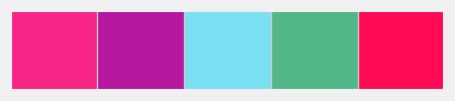

In [607]:
color_pal = [
    "#f72585",
    "#b5179e",
    "#7bdff2",
    "#52b788",
    "#ff0a54"
]

sns.set_palette(color_pal)
sns.palplot(color_pal)
plt.show()

In [419]:
total_data = len(data)
train_end = int(0.7 * total_data)
val_end = train_end + int(0.2 * total_data)

### Провести валідацію моделей типу SARIMA(X)

In [420]:
train_data = data.iloc[:train_end]['Production']
val_data = data.iloc[train_end:val_end]['Production']
test_data = data.iloc[val_end:]['Production']

In [421]:
queue = []

for p in range(3):
    for q in range(3):
        for P in range(3):
            for Q in range(3):
                    model = SARIMAX(train_data, order=(p, 0, q), seasonal_order=(P, 1, Q, 12), trend="ct").fit()
                    forecast_sarima = model.predict(start=len(train_data), end=len(train_data)+len(val_data)-1, dynamic=True)
                    mse_result = mean_squared_error(val_data, forecast_sarima)
                    heapq.heappush(queue, (-mse_result, p, q, P, Q))
                    if len(queue) > 10:
                        heapq.heappop(queue)


In [422]:
queue

[(-982.1545861726979, 2, 1, 0, 2),
 (-981.785180369448, 1, 0, 0, 1),
 (-976.19265295586, 1, 0, 0, 2),
 (-953.3122809277722, 2, 1, 2, 1),
 (-977.2745015292593, 2, 2, 2, 1),
 (-890.1322174756921, 2, 2, 1, 0),
 (-918.1774805773209, 2, 1, 1, 2),
 (-833.8338395642854, 2, 2, 2, 0),
 (-938.0274766464946, 1, 0, 1, 1),
 (-935.2293985474366, 1, 2, 2, 0)]

In [423]:
test_queue = []
train_combained_val = pd.concat([train_data, val_data])
for mse, p, q, P, Q in queue:
    model = SARIMAX(train_combained_val, order=(p, 0, q), seasonal_order=(P, 1, Q, 12), trend="ct").fit()
    forecast = model.predict(start=len(train_combained_val), end=len(train_combained_val)+len(test_data)-1, dynamic=True)
    mse_result = mean_squared_error(test_data, forecast)
    heapq.heappush(test_queue, (-mse_result, p, q, P, Q))
    if len(queue) > 10:
        heapq.heappop(test_queue)

In [424]:
test_queue

[(-1420.318584791092, 2, 2, 2, 1),
 (-1391.4749432489932, 2, 1, 2, 1),
 (-1327.3352514955695, 2, 1, 1, 2),
 (-1252.3043239236376, 1, 0, 1, 1),
 (-1263.877318768068, 1, 0, 0, 2),
 (-1216.9760862255723, 2, 2, 1, 0),
 (-1259.4666845948611, 1, 0, 0, 1),
 (-1216.5933854081934, 2, 1, 0, 2),
 (-1242.2299477155643, 2, 2, 2, 0),
 (-1256.897191525972, 1, 2, 2, 0)]

In [425]:
lowest_mse =  max(test_queue)

In [426]:
lowest_mse

(-1216.5933854081934, 2, 1, 0, 2)

In [427]:
mse, p, q, P, Q = lowest_mse
the_best_model = SARIMAX(train_combained_val, order=(p, 0, q), seasonal_order=(P, 1, Q, 12), trend="ct").fit()
forecast = the_best_model.predict(start=len(train_combained_val), end=len(train_combained_val)+len(test_data)-1, dynamic=True)

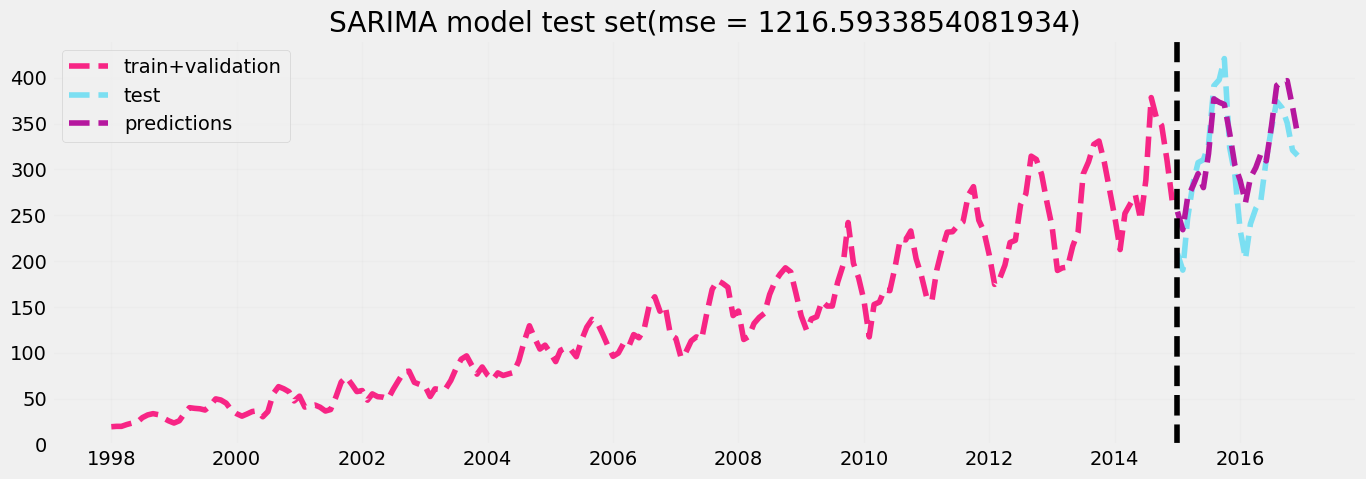

In [428]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(data['Date'].iloc[:val_end], train_combained_val, 'b--', color=color_pal[0], label="train+validation")
plt.plot(data['Date'].iloc[val_end:], test_data, color=color_pal[2], linestyle="--", label="test")
plt.plot(data['Date'].iloc[val_end:], forecast, 'r--', color=color_pal[1],  label="predictions")
ax.axvline(data['Date'].iloc[val_end:val_end + 1], color='black', ls='--')
plt.legend(loc='upper left')
plt.title(f"SARIMA model test set(mse = {-mse})")
plt.grid(alpha=0.1)

**Sarimax**

In [429]:
queue = []
for p in range(3):
    for q in range(3):
      for d in range(3):
          for P in range(3):
              for Q in range(3):
                      model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, 1, Q, 12), trend="ct").fit()
                      forecast_sarima = model.predict(start=len(train_data), end=len(train_data)+len(val_data)-1, dynamic=True)
                      mse_result = mean_squared_error(val_data, forecast_sarima)
                      heapq.heappush(queue, (-mse_result, p, q, d , P, Q))
                      if len(queue) > 10:
                          heapq.heappop(queue)


In [430]:
test_queue = []
train_combained_val = pd.concat([train_data, val_data])
for mse, p, q, d, P, Q in queue:
    model = SARIMAX(train_combained_val, order=(p, d, q), seasonal_order=(P, 1, Q, 12), trend="ct").fit()
    forecast = model.predict(start=len(train_combained_val), end=len(train_combained_val)+len(test_data)-1, dynamic=True)
    mse_result = mean_squared_error(test_data, forecast)
    heapq.heappush(test_queue, (-mse_result, p, q, d,  P, Q))
    if len(queue) > 10:
        heapq.heappop(test_queue)

In [431]:
lowest_mse =  max(test_queue)

In [432]:
lowest_mse

(-1138.2989455400962, 2, 1, 2, 1, 2)

In [433]:
mse, p, q, d, P, Q = lowest_mse
the_best_model = SARIMAX(train_combained_val, order=(p, 0, q), seasonal_order=(P, 1, Q, 12), trend="ct").fit()
forecast = the_best_model.predict(start=len(train_combained_val), end=len(train_combained_val)+len(test_data)-1, dynamic=True)

In [434]:
data

,Year,Month,Production,Diff_production,Date,Rainfall,Area_New,Area_ma,Area_ma_new,Area_npa,Area_rpa
0,1998,1,19.311,-8.946,1998-01-01,253.59,144.0,104.0,1.915385,248.0,1.0
1,1998,2,19.734,-409.531,1998-02-01,101.78,144.0,104.0,1.915385,248.0,1.0
2,1998,3,19.716,0.423,1998-03-01,170.31,144.0,104.0,1.915385,248.0,1.0
3,1998,4,21.720,-0.018,1998-04-01,261.26,144.0,104.0,1.915385,248.0,1.0
4,1998,5,23.252,2.004,1998-05-01,196.42,144.0,104.0,1.915385,248.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
223,2016,8,374.257,33.525,2016-08-01,200.55,238.0,1269.0,685.538462,1507.0,7.0
224,2016,9,367.147,29.672,2016-09-01,237.38,238.0,1269.0,685.538462,1507.0,7.0
225,2016,10,350.773,-7.110,2016-10-01,294.92,238.0,1269.0,685.538462,1507.0,7.0
226,2016,11,320.989,-16.374,2016-11-01,356.42,238.0,1269.0,685.538462,1507.0,7.0


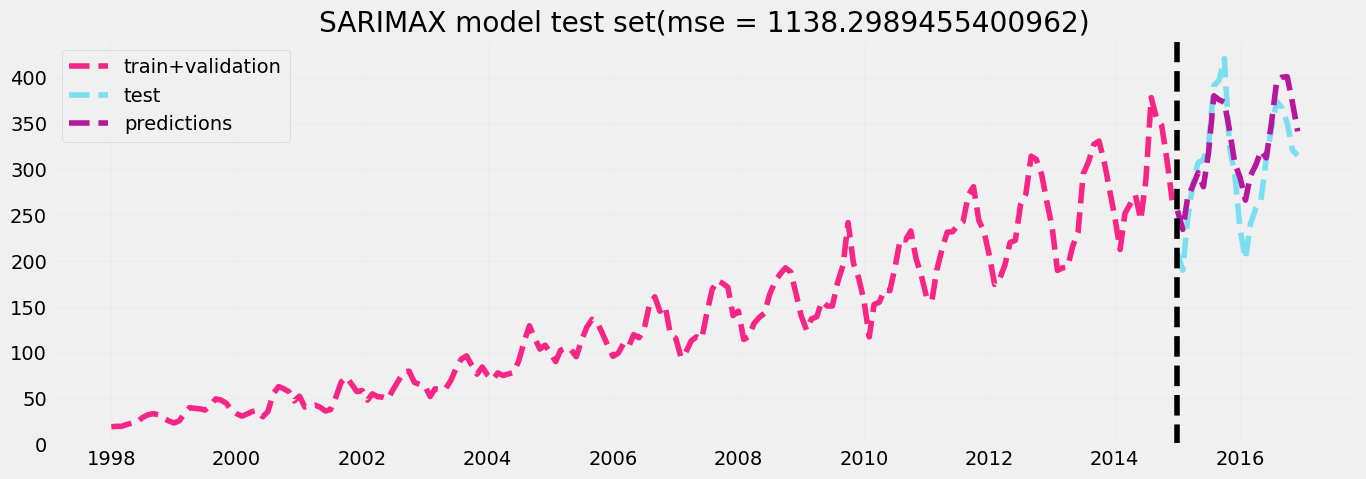

In [435]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(data['Date'].iloc[:val_end], train_combained_val, 'b--', color=color_pal[0], label="train+validation")
plt.plot(data['Date'].iloc[val_end:], test_data, color=color_pal[2], linestyle="--", label="test")
plt.plot(data['Date'].iloc[val_end:], forecast, 'r--', color=color_pal[1],  label="predictions")
ax.axvline(data['Date'].iloc[val_end:val_end + 1], color='black', ls='--')
plt.legend(loc='upper left')
plt.title(f"SARIMAX model test set(mse = {-mse})")
plt.grid(alpha=0.1)

Основна різниця між SARIMA та SARIMAX полягає в включенні екзогенних змінних в останню. Якщо є суттєві зовнішні фактори, які впливають на цільовий часовий ряд, то їх включення в модель може покращити точність прогнозу, що ми і бачимо у результатах.

### Генерація фіч та валідація ML моделей (тут на Ваш смак будь-які з відомих регресивних моделей). Інтегрувати екзогенні фактори, такі як опади, площі посівів і тп

Для цього завдання буду використовувати модель XGBoost та Lasso. Для початку згенерую HeatMap, щоб зрозуміти, які параметри з датасету площ краще вибирати у нашому випадку

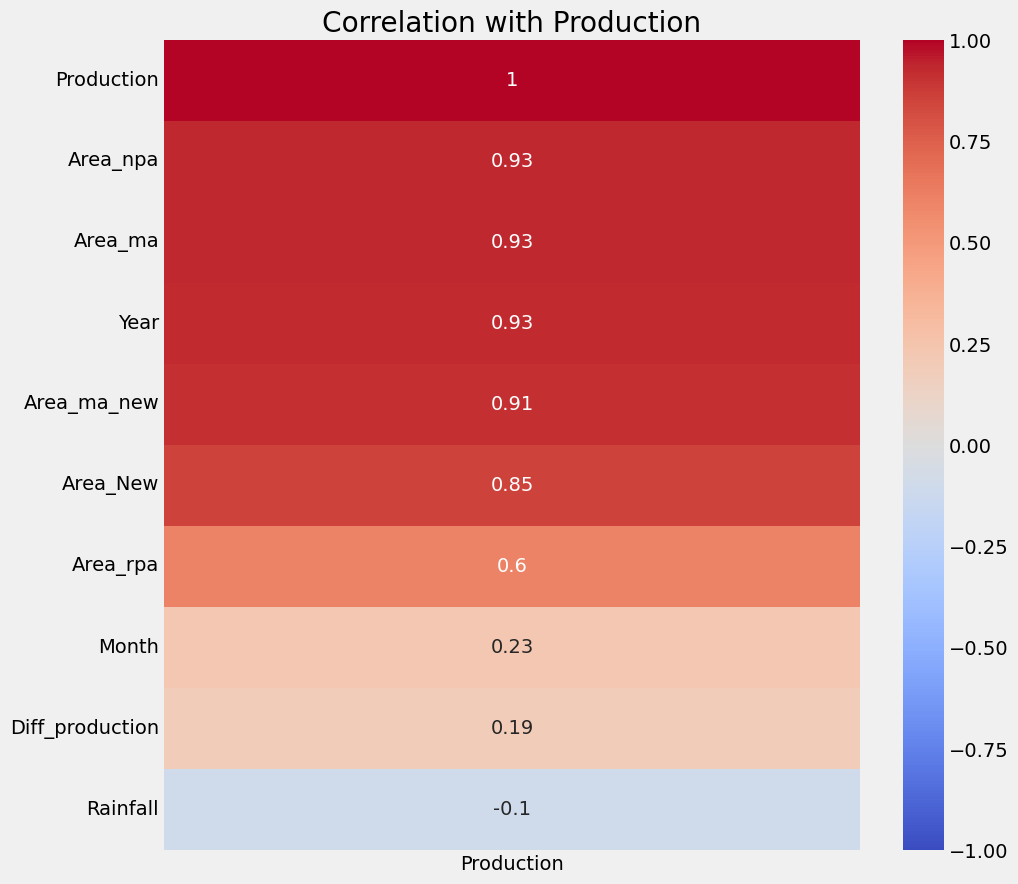

In [436]:
corr_matrix = data.corr()
prod_corr = corr_matrix[['Production']].sort_values(by='Production', ascending=False)
plt.figure(figsize=(10,10))
sns.heatmap(prod_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation with Production")
plt.show()

Щоб модель перформила краще,так як першопочатково результати зовсім невтішні,я вирішила згенерувати додаткові фічі щодо часу(година, день тижня, квартал, і так далі)

In [437]:
def create_features(data):
    """
    Create time series features based on time series index.
    """
    data = data.copy()
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['quarter'] = data.index.quarter
    data['dayofyear'] = data.index.dayofyear
    data['dayofmonth'] = data.index.day
    data['weekofyear'] = data.index.isocalendar().week
    return data

Також я згенерувала додаткові лаги для таких періодів: рік, два та три

In [438]:
def add_lags(data):
    target_map = data['Production'].to_dict()
    data['lag1'] = (data.index - pd.Timedelta('7 days')).map(target_map)
    data['lag2'] = (data.index - pd.Timedelta('30 days')).map(target_map)
    # data['lag3'] = (data.index - pd.Timedelta('1092 days')).map(target_map)
    return data


In [439]:
data.index = data.Date
data = data.drop(columns=['Date'])

In [440]:
def regressive_model(df, type=None):
    data = df.copy()
    fold = 0
    preds = []
    scores = []
    train_df = data.iloc[:train_end]
    val_df = data.iloc[train_end:val_end]
    test_df = data.iloc[val_end:]

    y_train = train_df['Production']
    X_train = train_df.drop(['Production'], axis=1)

    y_validation = val_df['Production']
    X_validation = val_df.drop(['Production'], axis=1)

    param_grid = {
        'n_estimators': [100, 500, 1000],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1],
        'colsample_bytree': [0.8, 0.9, 1],
        'objective': ['reg:linear']
    }

    model = xgb.XGBRegressor()
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_validation_pred = best_model.predict(X_validation)
    validation_score = np.sqrt(mean_squared_error(y_validation, y_validation_pred))
    print(f"Best Validation RMSE with {type}: {validation_score:.4f}")

In [441]:
regressive_model(data, 'initial parameters')

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Validation RMSE with initial parameters: 84.4082


Зараз створимо перші фічі:

In [442]:
data = create_features(data)

In [443]:
data

,Year,Month,Production,Diff_production,Rainfall,Area_New,Area_ma,Area_ma_new,Area_npa,Area_rpa,hour,dayofweek,quarter,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,,,,,
1998-01-01,1998,1,19.311,-8.946,253.59,144.0,104.0,1.915385,248.0,1.0,0,3,1,1,1,1
1998-02-01,1998,2,19.734,-409.531,101.78,144.0,104.0,1.915385,248.0,1.0,0,6,1,32,1,5
1998-03-01,1998,3,19.716,0.423,170.31,144.0,104.0,1.915385,248.0,1.0,0,6,1,60,1,9
1998-04-01,1998,4,21.720,-0.018,261.26,144.0,104.0,1.915385,248.0,1.0,0,2,2,91,1,14
1998-05-01,1998,5,23.252,2.004,196.42,144.0,104.0,1.915385,248.0,1.0,0,4,2,121,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-01,2016,8,374.257,33.525,200.55,238.0,1269.0,685.538462,1507.0,7.0,0,0,3,214,1,31
2016-09-01,2016,9,367.147,29.672,237.38,238.0,1269.0,685.538462,1507.0,7.0,0,3,3,245,1,35
2016-10-01,2016,10,350.773,-7.110,294.92,238.0,1269.0,685.538462,1507.0,7.0,0,5,4,275,1,39


In [444]:
regressive_model(data, 'time features')

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Validation RMSE with time features: 85.3891


In [446]:
fold = 0
preds = []
scores = []
train_df = data.iloc[:train_end]
val_df = data.iloc[train_end:val_end]
test_df = data.iloc[val_end:]

y_train = train_df['Production']
X_train = train_df.drop(['Production'], axis=1)

y_validation = val_df['Production']
X_validation = val_df.drop(['Production'], axis=1)

param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    'objective': ['reg:linear']
}
model = xgb.XGBRegressor()
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_validation_pred = best_model.predict(X_validation)
validation_score = np.sqrt(mean_squared_error(y_validation, y_validation_pred))
print(f"Best Validation RMSE with {type}: {validation_score:.4f}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Validation RMSE with <class 'type'>: 85.3891


In [447]:
X_full_train = pd.concat([X_train, X_validation])
y_full_train = pd.concat([y_train, y_validation])
best_rmse = float('inf')
y_test = test_df['Production']
X_test = test_df.drop(['Production'], axis=1)
best_model = None
top5_params = results_df.sort_values(by='rank_test_score').head(5)['params'].tolist()

for idx, params in enumerate(top5_params, 1):
    reg_final = xgb.XGBRegressor(**params)
    reg_final.fit(X_full_train, y_full_train,
                  eval_set=[(X_full_train, y_full_train)],
                  verbose=100)
    y_test_pred = reg_final.predict(X_test)
    test_score = np.sqrt(mean_squared_error(y_test, y_test_pred))

    if test_score < best_rmse:
        best_rmse = test_score
        best_model = reg_final

print(f"Best Model's Test RMSE: {best_rmse:.4f}")

[0]	validation_0-rmse:78.01226
[100]	validation_0-rmse:4.60759
[200]	validation_0-rmse:2.63885
[300]	validation_0-rmse:1.53375
[400]	validation_0-rmse:0.94744
[499]	validation_0-rmse:0.60334
[0]	validation_0-rmse:78.01226
[100]	validation_0-rmse:4.60759
[200]	validation_0-rmse:2.63885
[300]	validation_0-rmse:1.53375
[400]	validation_0-rmse:0.94744
[500]	validation_0-rmse:0.60052
[600]	validation_0-rmse:0.39762
[700]	validation_0-rmse:0.26124
[800]	validation_0-rmse:0.17631
[900]	validation_0-rmse:0.11590
[999]	validation_0-rmse:0.07972
[0]	validation_0-rmse:77.80892
[100]	validation_0-rmse:4.62022
[200]	validation_0-rmse:2.44354
[300]	validation_0-rmse:1.47773
[400]	validation_0-rmse:0.92901
[499]	validation_0-rmse:0.60244
[0]	validation_0-rmse:77.80892
[100]	validation_0-rmse:4.62022
[200]	validation_0-rmse:2.44354
[300]	validation_0-rmse:1.47773
[400]	validation_0-rmse:0.92901
[500]	validation_0-rmse:0.59970
[600]	validation_0-rmse:0.38959
[700]	validation_0-rmse:0.27344
[800]	valida

In [448]:
best_model_params = best_model.get_params()

In [449]:
reg_final = xgb.XGBRegressor(**best_model_params)
reg_final.fit(X_full_train, y_full_train,
                  eval_set=[(X_full_train, y_full_train)],
                  verbose=100)
y_test_pred = reg_final.predict(X_test)

[0]	validation_0-rmse:77.80892
[100]	validation_0-rmse:4.62022
[200]	validation_0-rmse:2.44354
[300]	validation_0-rmse:1.47773
[400]	validation_0-rmse:0.92901
[499]	validation_0-rmse:0.60244


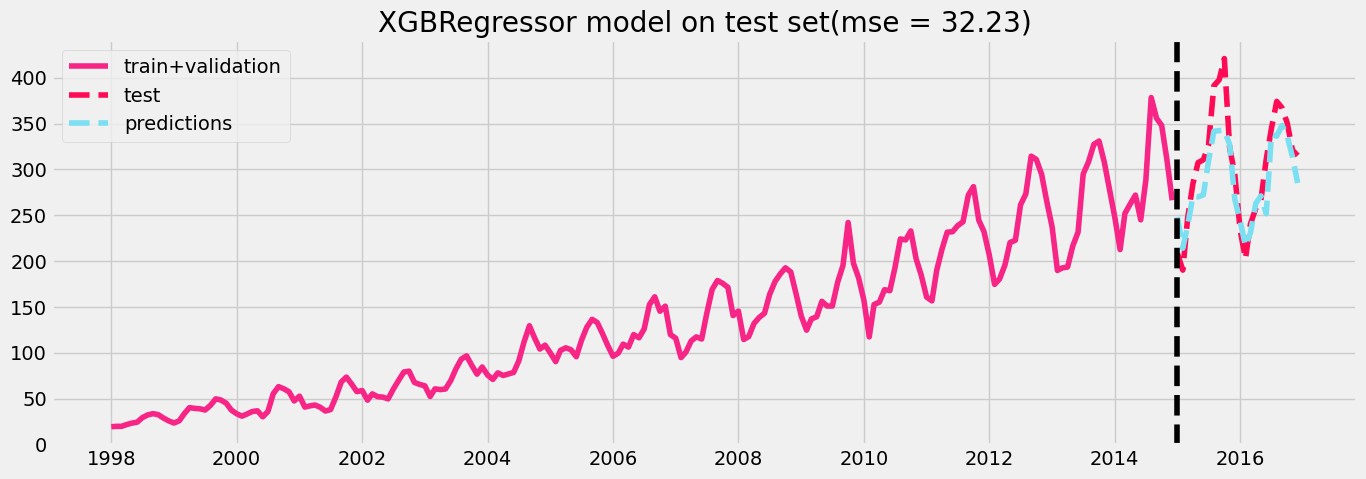

In [450]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(y_full_train, color=color_pal[0], label="train+validation")
plt.plot(y_test, color=color_pal[4], linestyle="--", label="test")
plt.plot(y_test.index, y_test_pred, color=color_pal[2],  linestyle="--", label="predictions")
ax.axvline(y_test.index[0], color='black', ls='--')
plt.legend(loc='upper left')
plt.title(f"XGBRegressor model on test set(mse = {best_rmse:.2f})")
plt.show()

Тепер спробуємо додати лаги.

In [451]:
data = add_lags(data)

In [452]:
data

,Year,Month,Production,Diff_production,Rainfall,Area_New,Area_ma,Area_ma_new,Area_npa,Area_rpa,hour,dayofweek,quarter,dayofyear,dayofmonth,weekofyear,lag1,lag2
Date,,,,,,,,,,,,,,,,,,
1998-01-01,1998,1,19.311,-8.946,253.59,144.0,104.0,1.915385,248.0,1.0,0,3,1,1,1,1,NaN,NaN
1998-02-01,1998,2,19.734,-409.531,101.78,144.0,104.0,1.915385,248.0,1.0,0,6,1,32,1,5,NaN,NaN
1998-03-01,1998,3,19.716,0.423,170.31,144.0,104.0,1.915385,248.0,1.0,0,6,1,60,1,9,NaN,NaN
1998-04-01,1998,4,21.720,-0.018,261.26,144.0,104.0,1.915385,248.0,1.0,0,2,2,91,1,14,NaN,NaN
1998-05-01,1998,5,23.252,2.004,196.42,144.0,104.0,1.915385,248.0,1.0,0,4,2,121,1,18,NaN,21.720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-01,2016,8,374.257,33.525,200.55,238.0,1269.0,685.538462,1507.0,7.0,0,0,3,214,1,31,NaN,NaN
2016-09-01,2016,9,367.147,29.672,237.38,238.0,1269.0,685.538462,1507.0,7.0,0,3,3,245,1,35,NaN,NaN
2016-10-01,2016,10,350.773,-7.110,294.92,238.0,1269.0,685.538462,1507.0,7.0,0,5,4,275,1,39,NaN,367.147


In [453]:
regressive_model(data, 'lags')

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Validation RMSE with lags: 80.1198


In [454]:
results_df = pd.DataFrame(grid_search.cv_results_)
top5 = results_df.sort_values(by='rank_test_score').head(5)
for i, row in top5.iterrows():
    print(f"Model rank: {row['rank_test_score']}")
    print(f"Mean validation score (RMSE): {-row['mean_test_score']**0.5:.4f}")
    print(f"Hyperparameters: {row['params']}\n")

Model rank: 1
Mean validation score (RMSE): -0.0000-33.8113j
Hyperparameters: {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'objective': 'reg:linear', 'subsample': 1}

Model rank: 2
Mean validation score (RMSE): -0.0000-33.8138j
Hyperparameters: {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000, 'objective': 'reg:linear', 'subsample': 1}

Model rank: 3
Mean validation score (RMSE): -0.0000-33.9826j
Hyperparameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'objective': 'reg:linear', 'subsample': 1}

Model rank: 4
Mean validation score (RMSE): -0.0000-33.9850j
Hyperparameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000, 'objective': 'reg:linear', 'subsample': 1}

Model rank: 5
Mean validation score (RMSE): -0.0000-34.0858j
Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'objective': 

In [455]:
fold = 0
preds = []
scores = []
train_df = data.iloc[:train_end]
val_df = data.iloc[train_end:val_end]
test_df = data.iloc[val_end:]

y_train = train_df['Production']
X_train = train_df.drop(['Production'], axis=1)

y_validation = val_df['Production']
X_validation = val_df.drop(['Production'], axis=1)

param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    'objective': ['reg:linear']
}

model = xgb.XGBRegressor()
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_validation_pred = best_model.predict(X_validation)
validation_score = np.sqrt(mean_squared_error(y_validation, y_validation_pred))
print(f"Best Validation RMSE with {type}: {validation_score:.4f}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Validation RMSE with <class 'type'>: 80.1198


In [456]:
results_df = pd.DataFrame(grid_search.cv_results_)
top5 = results_df.sort_values(by='rank_test_score').head(5)
for i, row in top5.iterrows():
    print(f"Model rank: {row['rank_test_score']}")
    print(f"Mean validation score (RMSE): {-row['mean_test_score']**0.5:.4f}")
    print(f"Hyperparameters: {row['params']}\n")

Model rank: 1
Mean validation score (RMSE): -0.0000-33.7303j
Hyperparameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'objective': 'reg:linear', 'subsample': 1}

Model rank: 2
Mean validation score (RMSE): -0.0000-33.7326j
Hyperparameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000, 'objective': 'reg:linear', 'subsample': 1}

Model rank: 3
Mean validation score (RMSE): -0.0000-33.7589j
Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000, 'objective': 'reg:linear', 'subsample': 1}

Model rank: 4
Mean validation score (RMSE): -0.0000-33.7786j
Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'objective': 'reg:linear', 'subsample': 1}

Model rank: 5
Mean validation score (RMSE): -0.0000-33.7896j
Hyperparameters: {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'objective

In [457]:
top5['params']

221    {'colsample_bytree': 1, 'learning_rate': 0.1, ...
224    {'colsample_bytree': 1, 'learning_rate': 0.1, ...
116    {'colsample_bytree': 0.9, 'learning_rate': 0.0...
113    {'colsample_bytree': 0.9, 'learning_rate': 0.0...
194    {'colsample_bytree': 1, 'learning_rate': 0.05,...
Name: params, dtype: object

In [458]:
top5

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_objective,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
221,0.245518,0.008016,0.008778,0.000130,1,0.1,3,500,reg:linear,1,"{'colsample_bytree': 1, 'learning_rate': 0.1, ...",-702.821825,-915.961839,-1794.424936,-1137.736200,472.431468,1
224,0.465959,0.002428,0.010331,0.001039,1,0.1,3,1000,reg:linear,1,"{'colsample_bytree': 1, 'learning_rate': 0.1, ...",-703.675392,-915.755721,-1794.240321,-1137.890478,472.116408,2
116,0.691957,0.167339,0.012251,0.003588,0.9,0.05,3,1000,reg:linear,1,"{'colsample_bytree': 0.9, 'learning_rate': 0.0...",-721.359331,-914.531163,-1783.103261,-1139.664585,461.763891,3
113,0.465324,0.022271,0.026141,0.004766,0.9,0.05,3,500,reg:linear,1,"{'colsample_bytree': 0.9, 'learning_rate': 0.0...",-718.698175,-920.803064,-1783.474456,-1140.991898,461.735476,4
194,0.245063,0.008193,0.009659,0.000476,1,0.05,3,500,reg:linear,1,"{'colsample_bytree': 1, 'learning_rate': 0.05,...",-714.280336,-917.814065,-1793.121228,-1141.738543,468.032083,5


In [459]:
X_full_train = pd.concat([X_train, X_validation])
y_full_train = pd.concat([y_train, y_validation])
best_rmse = float('inf')
y_test = test_df['Production']
X_test = test_df.drop(['Production'], axis=1)
best_model = None
top5_params = results_df.sort_values(by='rank_test_score').head(5)['params'].tolist()

for idx, params in enumerate(top5_params, 1):
    reg_final = xgb.XGBRegressor(**params)
    reg_final.fit(X_full_train, y_full_train,
                  eval_set=[(X_full_train, y_full_train)],
                  verbose=100)
    y_test_pred = reg_final.predict(X_test)
    test_score = np.sqrt(mean_squared_error(y_test, y_test_pred))

    if test_score < best_rmse:
        best_rmse = test_score
        best_model = reg_final

print(f"Best Model's Test RMSE: {best_rmse:.4f}")

[0]	validation_0-rmse:77.80892
[100]	validation_0-rmse:4.53498
[200]	validation_0-rmse:2.49937
[300]	validation_0-rmse:1.47450
[400]	validation_0-rmse:0.90224
[499]	validation_0-rmse:0.59606
[0]	validation_0-rmse:77.80892
[100]	validation_0-rmse:4.53498
[200]	validation_0-rmse:2.49937
[300]	validation_0-rmse:1.47450
[400]	validation_0-rmse:0.90224
[500]	validation_0-rmse:0.59295
[600]	validation_0-rmse:0.40314
[700]	validation_0-rmse:0.27322
[800]	validation_0-rmse:0.18167
[900]	validation_0-rmse:0.12568
[999]	validation_0-rmse:0.08889
[0]	validation_0-rmse:81.62836
[100]	validation_0-rmse:7.26126
[200]	validation_0-rmse:4.60959
[300]	validation_0-rmse:3.52504
[400]	validation_0-rmse:2.75473
[500]	validation_0-rmse:2.07771
[600]	validation_0-rmse:1.62532
[700]	validation_0-rmse:1.30556
[800]	validation_0-rmse:1.05301
[900]	validation_0-rmse:0.85467
[999]	validation_0-rmse:0.69122
[0]	validation_0-rmse:81.62836
[100]	validation_0-rmse:7.26126
[200]	validation_0-rmse:4.60959
[300]	valida

In [460]:
best_model_params = best_model.get_params()

In [461]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, objective='reg:linear', ...)

In [462]:
reg_final = xgb.XGBRegressor(**best_model_params)
reg_final.fit(X_full_train, y_full_train,
                  eval_set=[(X_full_train, y_full_train)],
                  verbose=100)
y_test_pred = reg_final.predict(X_test)

[0]	validation_0-rmse:77.80892
[100]	validation_0-rmse:4.53498
[200]	validation_0-rmse:2.49937
[300]	validation_0-rmse:1.47450
[400]	validation_0-rmse:0.90224
[499]	validation_0-rmse:0.59606


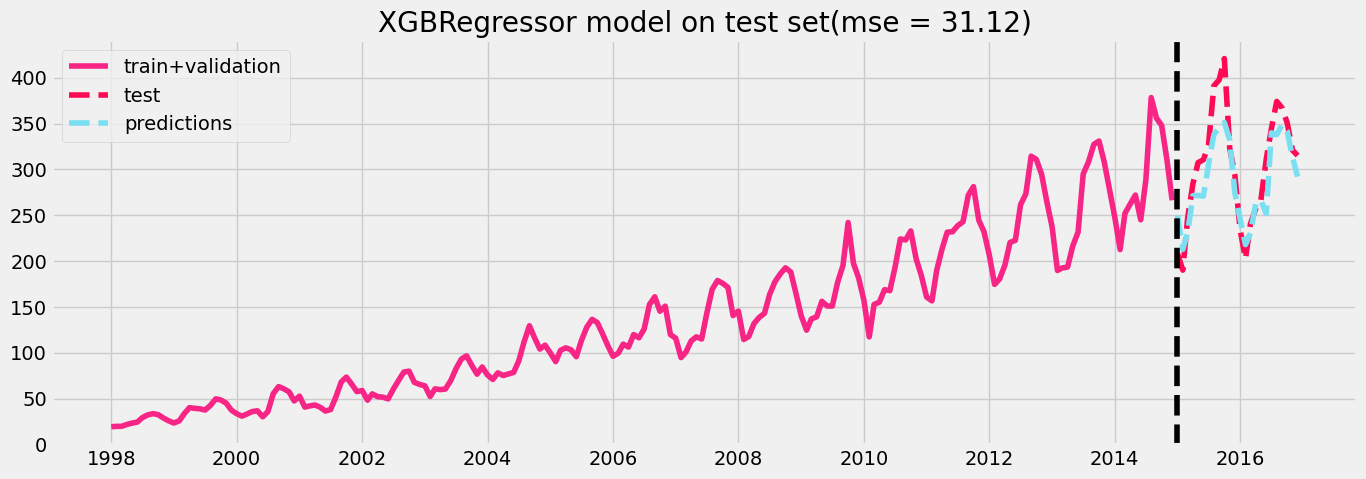

In [463]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(y_full_train, color=color_pal[0], label="train+validation")
plt.plot(y_test, color=color_pal[4], linestyle="--", label="test")
plt.plot(y_test.index, y_test_pred, color=color_pal[2],  linestyle="--", label="predictions")
ax.axvline(y_test.index[0], color='black', ls='--')
plt.legend(loc='upper left')
plt.title(f"XGBRegressor model on test set(mse = {best_rmse:.2f})")
plt.show()

Додавання лагів покращило нашу модель.

Lasso model

In [465]:
fold = 0
preds = []
scores = []

train_df = data.iloc[:train_end]
val_df = data.iloc[train_end:val_end]
test_df = data.iloc[val_end:]

y_train = train_df['Production']
X_train = train_df.drop(['Diff_production', 'lag1', 'lag2', 'Production'], axis=1)

y_validation = val_df['Production']
X_validation = val_df.drop(['Diff_production', 'lag1', 'lag2','Production'], axis=1)


param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'fit_intercept': [True, False],
    'max_iter': [1000, 5000, 10000]
}


model = Lasso()
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_validation_pred = best_model.predict(X_validation)
validation_score = np.sqrt(mean_squared_error(y_validation, y_validation_pred))
print(f"Best Validation RMSE with Lasso: {validation_score:.4f}")


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Validation RMSE with Lasso: 39.6027


In [466]:
results_df = pd.DataFrame(grid_search.cv_results_)
top = results_df.sort_values(by='rank_test_score').head(10)

for i, row in top.iterrows():
    print(f"Model rank: {row['rank_test_score']}")
    print(f"Mean validation score (RMSE): {-row['mean_test_score']**0.5:.4f}")
    print(f"Hyperparameters: {row['params']}\n")


Model rank: 1
Mean validation score (RMSE): -0.0000-28.6648j
Hyperparameters: {'alpha': 10, 'fit_intercept': False, 'max_iter': 5000}

Model rank: 2
Mean validation score (RMSE): -0.0000-28.6926j
Hyperparameters: {'alpha': 10, 'fit_intercept': False, 'max_iter': 10000}

Model rank: 3
Mean validation score (RMSE): -0.0000-28.7232j
Hyperparameters: {'alpha': 10, 'fit_intercept': True, 'max_iter': 1000}

Model rank: 4
Mean validation score (RMSE): -0.0000-28.7268j
Hyperparameters: {'alpha': 10, 'fit_intercept': True, 'max_iter': 10000}

Model rank: 4
Mean validation score (RMSE): -0.0000-28.7268j
Hyperparameters: {'alpha': 10, 'fit_intercept': True, 'max_iter': 5000}

Model rank: 6
Mean validation score (RMSE): -0.0000-28.8066j
Hyperparameters: {'alpha': 10, 'fit_intercept': False, 'max_iter': 1000}

Model rank: 7
Mean validation score (RMSE): -0.0000-29.2492j
Hyperparameters: {'alpha': 0.1, 'fit_intercept': True, 'max_iter': 1000}

Model rank: 8
Mean validation score (RMSE): -0.0000-30.5

In [471]:
X_full_train = pd.concat([X_train, X_validation])
y_full_train = pd.concat([y_train, y_validation])

best_rmse = float('inf')
y_test = test_df['Production']
X_test = test_df.drop(['Production',  'lag1', 'lag2', 'Diff_production'], axis=1)
best_model = None
top_params = results_df.sort_values(by='rank_test_score').head(10)['params'].tolist()

for idx, params in enumerate(top_params, 1):
    reg_final = Lasso(**params)
    reg_final.fit(X_full_train, y_full_train)
    y_test_pred = reg_final.predict(X_test)
    test_score = np.sqrt(mean_squared_error(y_test, y_test_pred))
    if test_score < best_rmse:
        best_rmse = test_score
        best_model = reg_final

print(f"Best Model's Test RMSE: {best_rmse:.4f}")

Best Model's Test RMSE: 59.3285


In [472]:
best_model

Lasso(alpha=0.1)

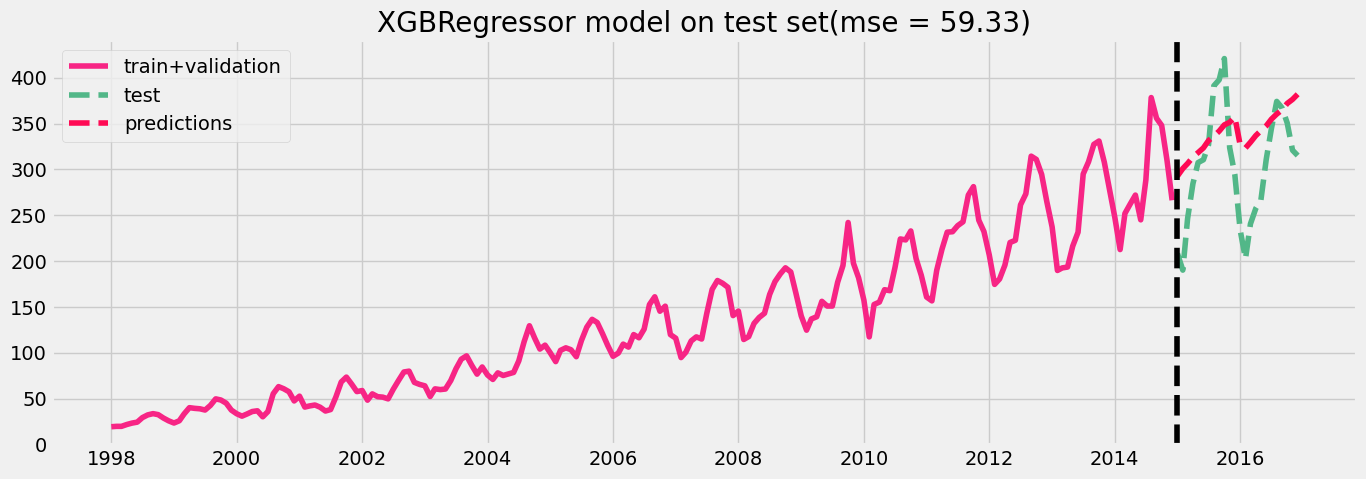

In [473]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(y_full_train.index, y_full_train, color=color_pal[0], label="train+validation")
plt.plot(y_test.index, y_test, color=color_pal[3], linestyle="--", label="test")
plt.plot(y_test.index, y_test_pred, color=color_pal[4], linestyle="--", label="predictions")
ax.axvline(y_test.index[0], color='black', ls='--')
plt.legend(loc='upper left')
plt.title(f"XGBRegressor model on test set(mse = {best_rmse:.2f})")
plt.show()


Як можна помітити XGBoost передбачає краще, ніж Lasso, і от можливі причини чому:

*   XGBoos може вловлювати складні нелінійні залежності в даних, послідовно додаючи дерева, а Lasso це лінійна модель. Якщо справжній зв'язок між ознаками та цільовою змінною є нелінійним, Lasso може не вловлювати це так ефективно, як XGBoost.
*    XGBoost включає L1 (Lasso) та L2 (Ridge) регуляризацію у свою цільову функцію, що допомагає запобігти перенавчанню, особливо коли кількість дерев або глибина збільшується, а Lasso використовує L1 регуляризацію, яка може скорочувати деякі коефіцієнти до нуля, що може не працювати добре, якщо є багато ознак.
*    XGBoost має вбудований механізм для обробки відсутніх даних, а Lasso вимагає видалення  відсутніх значень перед навчанням.



### Валідація Facebook Prophet

In [474]:
production_train_prophet = train_df.reset_index() \
    .rename(columns={'Date':'ds',
                     'Production':'y'})

In [475]:
production_validation_prophet = val_df.reset_index() \
    .rename(columns={'Date':'ds',
                     'Production':'y'})

In [476]:
production_test_prophet = test_df.reset_index() \
    .rename(columns={'Date':'ds',
                     'Production':'y'})

In [477]:
production_train_prophet = production_train_prophet[['ds', 'y']]

In [478]:
production_validation_prophet = production_validation_prophet[['ds', 'y']]

In [479]:
production_test_prophet = production_test_prophet[['ds', 'y']]

In [480]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

results = []

for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
    for seasonality_prior_scale in param_grid['seasonality_prior_scale']:

        m = Prophet(
            changepoint_prior_scale=changepoint_prior_scale,
            seasonality_prior_scale=seasonality_prior_scale,
            weekly_seasonality=True,
            daily_seasonality=True
        )
        m.fit(production_train_prophet)
        future = m.make_future_dataframe(periods=len(production_validation_prophet))
        forecast = m.predict(future)
        predictions = forecast['yhat'][-len(production_validation_prophet):]
        rmse = mean_squared_error(production_validation_prophet['y'], predictions, squared=False)
        results.append((rmse, {'changepoint_prior_scale': changepoint_prior_scale, 'seasonality_prior_scale': seasonality_prior_scale}))
top_5_params = sorted(results)[:5]

for rmse, params in top_5_params:
    print(f"Validation RMSE: {rmse}, Params: {params}")


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0kv50uwr/vpwdbigw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0kv50uwr/cab494ny.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2514', 'data', 'file=/tmp/tmp0kv50uwr/vpwdbigw.json', 'init=/tmp/tmp0kv50uwr/cab494ny.json', 'output', 'file=/tmp/tmp0kv50uwr/prophet_modelhbwduxc1/prophet_model-20231031142431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:24:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:24:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0kv50uwr/qe977_zh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0kv50uwr/qikd_zn9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Validation RMSE: 89.20759477842807, Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}
Validation RMSE: 90.10401570436318, Params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}
Validation RMSE: 94.24283121477907, Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
Validation RMSE: 94.57154364421058, Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}
Validation RMSE: 95.40680913986542, Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}


In [481]:
results_test = []
train_valid_df = pd.concat([production_train_prophet,production_validation_prophet])
for rmse, params in top_5_params:
    m = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        weekly_seasonality=True,
        daily_seasonality=True
    )

    m.fit(train_valid_df)
    future = m.make_future_dataframe(periods=len(production_test_prophet))
    forecast = m.predict(future)

    predictions = forecast['yhat'][-len(production_test_prophet):]
    rmse_test = mean_squared_error(production_test_prophet['y'], predictions, squared=False)
    results_test.append((rmse_test, params))

sorted_results_test = sorted(results_test)

for rmse, params in sorted_results_test:
    print(f"Test RMSE: {rmse}, Params: {params}")


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0kv50uwr/wsweqan0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0kv50uwr/b82nlzlj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18821', 'data', 'file=/tmp/tmp0kv50uwr/wsweqan0.json', 'init=/tmp/tmp0kv50uwr/b82nlzlj.json', 'output', 'file=/tmp/tmp0kv50uwr/prophet_model132jqqi0/prophet_model-20231031142434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:24:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:24:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0kv50uwr/vdo323s_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0kv50uwr/m18lsdvy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Test RMSE: 62.46512365500121, Params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}
Test RMSE: 62.54718735089181, Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}
Test RMSE: 67.20714781963417, Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
Test RMSE: 72.466474055726, Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}
Test RMSE: 73.44144148859027, Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}


In [482]:
changepoint_prior_scale, seasonality_prior_scale = sorted_results_test[0][1].values()

In [483]:
sorted_results_test

[(62.46512365500121,
  {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}),
 (62.54718735089181,
  {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}),
 (67.20714781963417,
  {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}),
 (72.466474055726,
  {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}),
 (73.44144148859027,
  {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0})]

In [484]:
m = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
    )

m.fit(train_valid_df)
future = m.make_future_dataframe(periods=len(production_test_prophet), freq='M')
forecast = m.predict(future)
predictions = forecast['yhat'][-len(production_test_prophet):]
mse_test = mean_squared_error(production_test_prophet['y'], predictions, squared=False)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0kv50uwr/5rdyc0aj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0kv50uwr/liiossai.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30059', 'data', 'file=/tmp/tmp0kv50uwr/5rdyc0aj.json', 'init=/tmp/tmp0kv50uwr/liiossai.json', 'output', 'file=/tmp/tmp0kv50uwr/prophet_modelp5tilmuq/prophet_model-20231031142435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:24:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:24:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


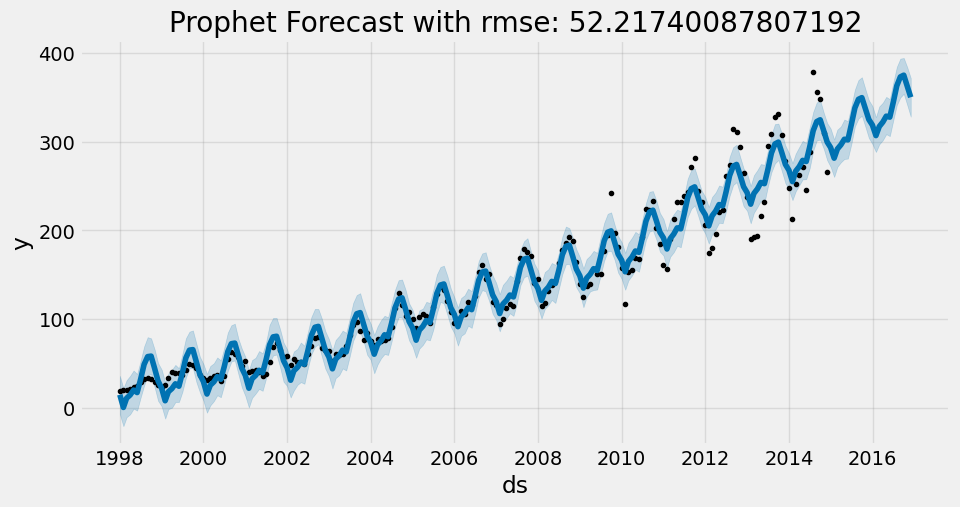

In [485]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = m.plot(forecast, ax=ax)
ax.set_title(f'Prophet Forecast with rmse: {mse_test}')
plt.show()

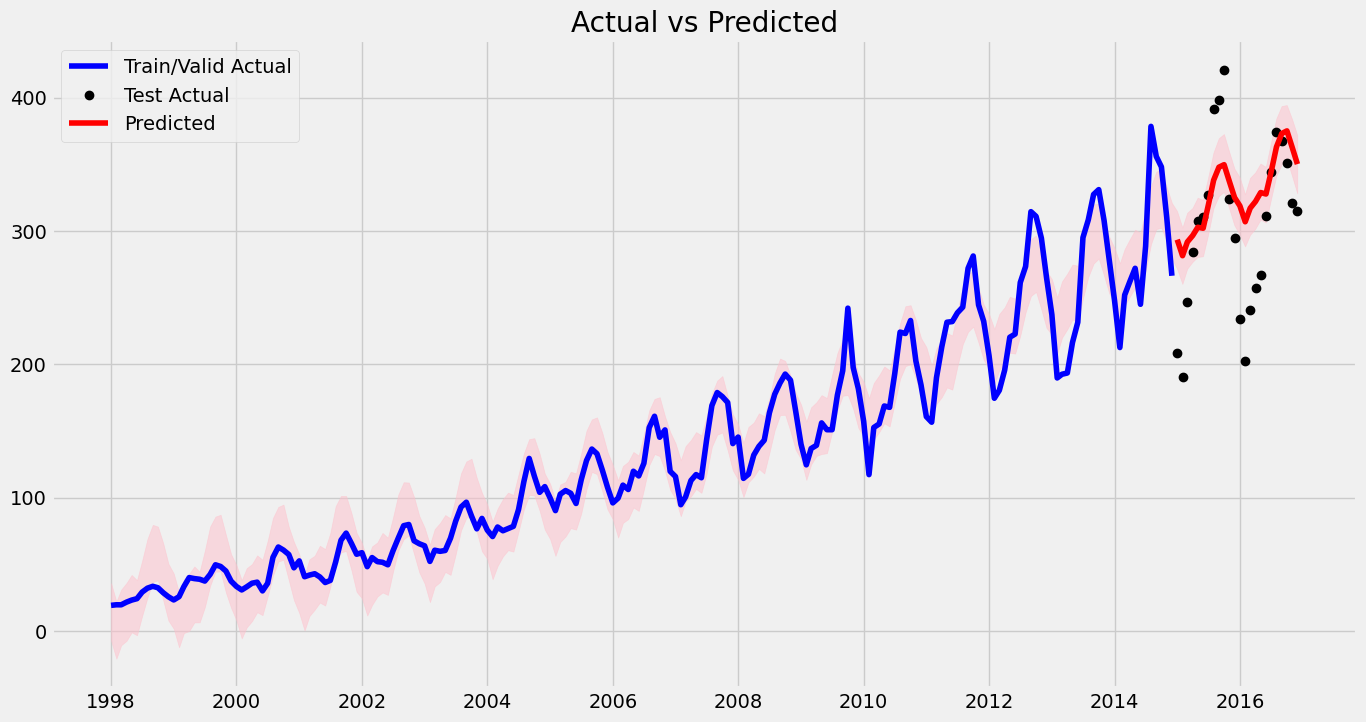

In [486]:
plt.figure(figsize=(15, 8))
plt.plot(train_valid_df['ds'], train_valid_df['y'], label='Train/Valid Actual', color='blue')
plt.plot(production_test_prophet['ds'], production_test_prophet['y'], 'o', label='Test Actual', color='black')
plt.plot(production_test_prophet['ds'], forecast['yhat'][-len(production_test_prophet):], label='Predicted', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.5)
plt.title('Actual vs Predicted')
plt.legend()
plt.show()


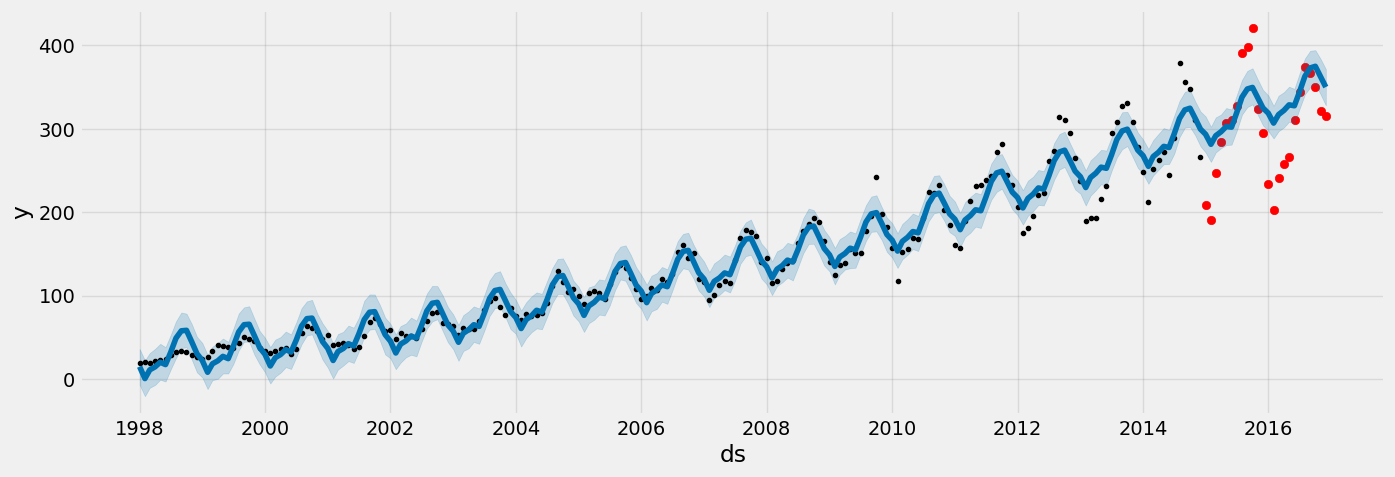

In [487]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test_df.index, production_test_prophet['y'], color='r')
fig = m.plot(forecast, ax=ax)

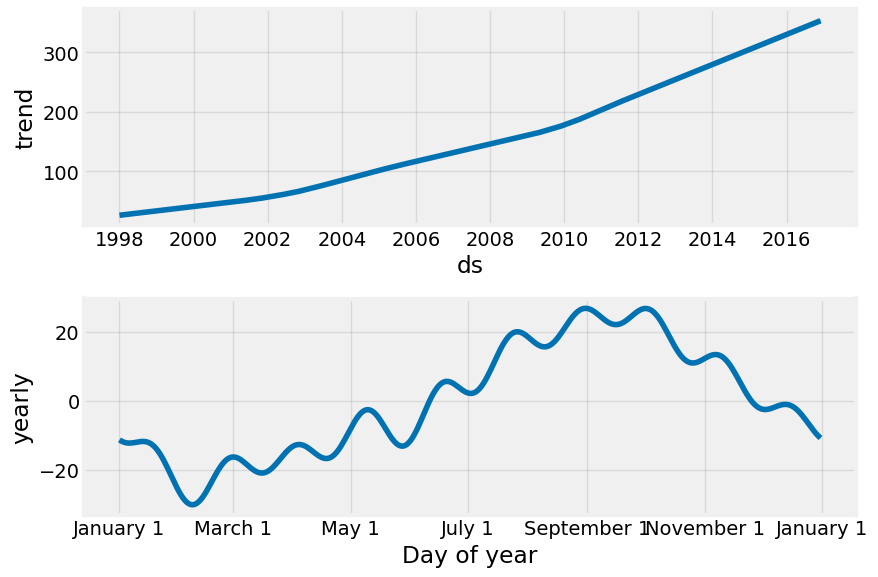

In [488]:
fig = m.plot_components(forecast)
plt.show()

In [489]:
predicted = forecast['yhat'][-len(production_test_prophet):]
actual = production_test_prophet['y']
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 41.68794865310648
RMSE: 52.21740087807192


Додамо в модель свята у Малазії

In [490]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

results = []

for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
    for seasonality_prior_scale in param_grid['seasonality_prior_scale']:

        m = Prophet(
            changepoint_prior_scale=changepoint_prior_scale,
            seasonality_prior_scale=seasonality_prior_scale
        )

        m.add_country_holidays(country_name='MY')

        m.fit(production_train_prophet)
        future = m.make_future_dataframe(periods=len(production_validation_prophet))
        forecast = m.predict(future)
        predictions = forecast['yhat'][-len(production_validation_prophet):]
        rmse = mean_squared_error(production_validation_prophet['y'], predictions, squared=False)
        results.append((rmse, {'changepoint_prior_scale': changepoint_prior_scale, 'seasonality_prior_scale': seasonality_prior_scale}))

top_5_params = sorted(results)[:5]

for rmse, params in top_5_params:
    print(f"Validation RMSE: {rmse}, Params: {params}")


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0kv50uwr/sn2hlgwc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0kv50uwr/zz0rlbh6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22356', 'data', 'file=/tmp/tmp0kv50uwr/sn2hlgwc.json', 'init=/tmp/tmp0kv50uwr/zz0rlbh6.json', 'output', 'file=/tmp/tmp0kv50uwr/prophet_modeld6r7ric7/prophet_model-20231031142437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:24:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:24:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

Validation RMSE: 88.827520790727, Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}
Validation RMSE: 89.81779142493627, Params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}
Validation RMSE: 93.87016067883026, Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
Validation RMSE: 95.26790403370617, Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}
Validation RMSE: 95.68179780484077, Params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1}


In [491]:
results_test = []
train_valid_df = pd.concat([production_train_prophet,production_validation_prophet])
for rmse, params in top_5_params:
    m = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
    )
    m.add_country_holidays(country_name='MY')
    m.fit(train_valid_df)
    future = m.make_future_dataframe(periods=len(production_test_prophet))
    forecast = m.predict(future)

    predictions = forecast['yhat'][-len(production_test_prophet):]
    rmse_test = mean_squared_error(production_test_prophet['y'], predictions, squared=False)
    results_test.append((rmse_test, params))

sorted_results_test = sorted(results_test)

for rmse, params in sorted_results_test:
    print(f"Test RMSE: {rmse}, Params: {params}")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0kv50uwr/c323fn9s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0kv50uwr/dfodzko3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85959', 'data', 'file=/tmp/tmp0kv50uwr/c323fn9s.json', 'init=/tmp/tmp0kv50uwr/dfodzko3.json', 'output', 'file=/tmp/tmp0kv50uwr/prophet_modelgnvnopcu/prophet_model-20231031142448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:24:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:24:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

Test RMSE: 61.73719568176, Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}
Test RMSE: 61.83586094868621, Params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1}
Test RMSE: 62.47378031465949, Params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}
Test RMSE: 62.528018290910396, Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}
Test RMSE: 66.38220657686188, Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


In [492]:
changepoint_prior_scale, seasonality_prior_scale = sorted_results_test[0][1].values()

In [493]:
m = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
    )
m.add_country_holidays(country_name='MY')
m.fit(train_valid_df)
future = m.make_future_dataframe(periods=len(production_test_prophet), freq='M')
forecast = m.predict(future)
predictions = forecast['yhat'][-len(production_test_prophet):]
mse_test = mean_squared_error(production_test_prophet['y'], predictions, squared=False)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0kv50uwr/oa37s511.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0kv50uwr/uu2vcfkc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35180', 'data', 'file=/tmp/tmp0kv50uwr/oa37s511.json', 'init=/tmp/tmp0kv50uwr/uu2vcfkc.json', 'output', 'file=/tmp/tmp0kv50uwr/prophet_model_39f8tb1/prophet_model-20231031142450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:24:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:24:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


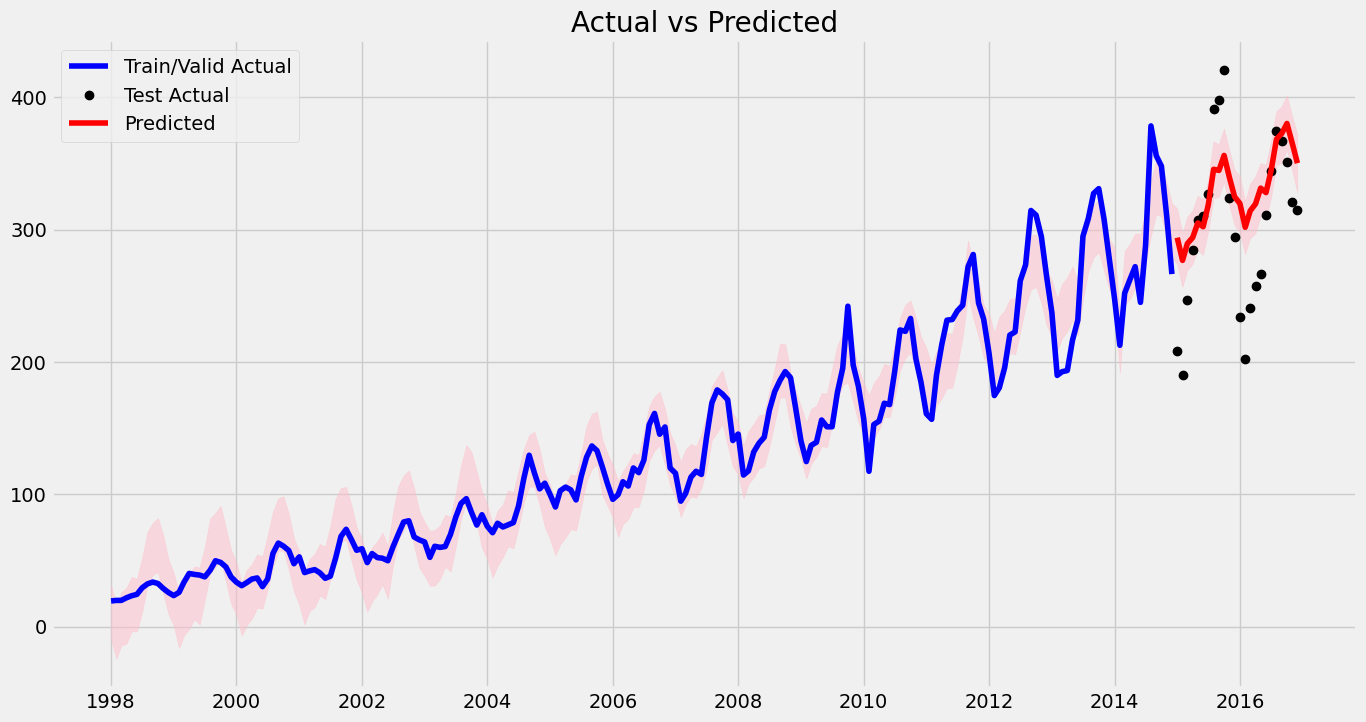

In [494]:
plt.figure(figsize=(15, 8))
plt.plot(train_valid_df['ds'], train_valid_df['y'], label='Train/Valid Actual', color='blue')
plt.plot(production_test_prophet['ds'], production_test_prophet['y'], 'o', label='Test Actual', color='black')
plt.plot(production_test_prophet['ds'], forecast['yhat'][-len(production_test_prophet):], label='Predicted', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.5)
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

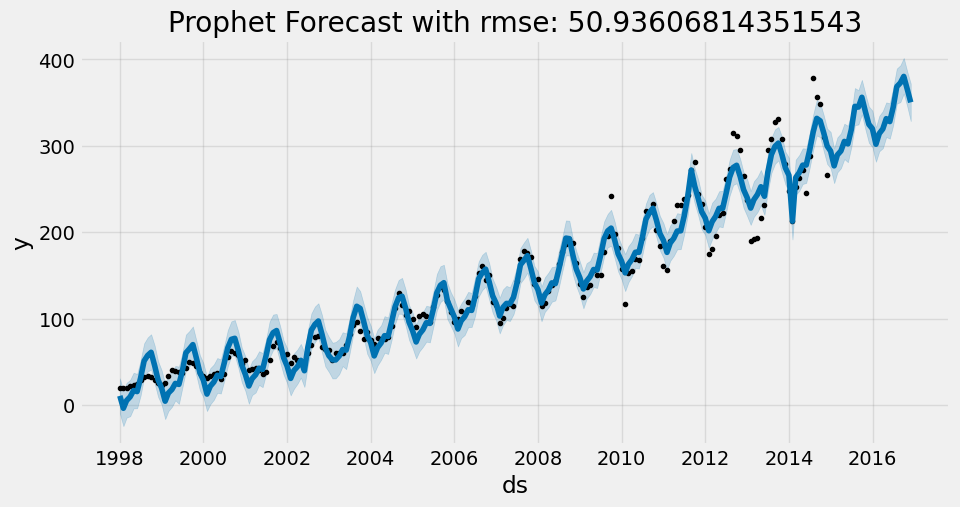

In [495]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = m.plot(forecast, ax=ax)
ax.set_title(f'Prophet Forecast with rmse: {mse_test}')
plt.show()

Включення у модель свят покращило її точність.

Порівняючи Prophet з іншими моделями часових рядів, можна помітити, що Prophet надає більше гнучкості та можливостей для моделювання специфічних особливостей часових рядів, особливо коли дані містять нелінійні тренди, сезонність та вплив свят.

Додатково, коли мова йде про множникову модель, Prophet дозволяє моделювати сезонний ефект, який збільшується або зменшується у пропорції до рівня часового ряду, що може бути дуже корисним для деяких даних.

### Валідація додавання множників Фур’є в модель

In [496]:
train_data = data.iloc[:train_end]['Production']
val_data = data.iloc[train_end:val_end]['Production']
test_data = data.iloc[val_end:]['Production']

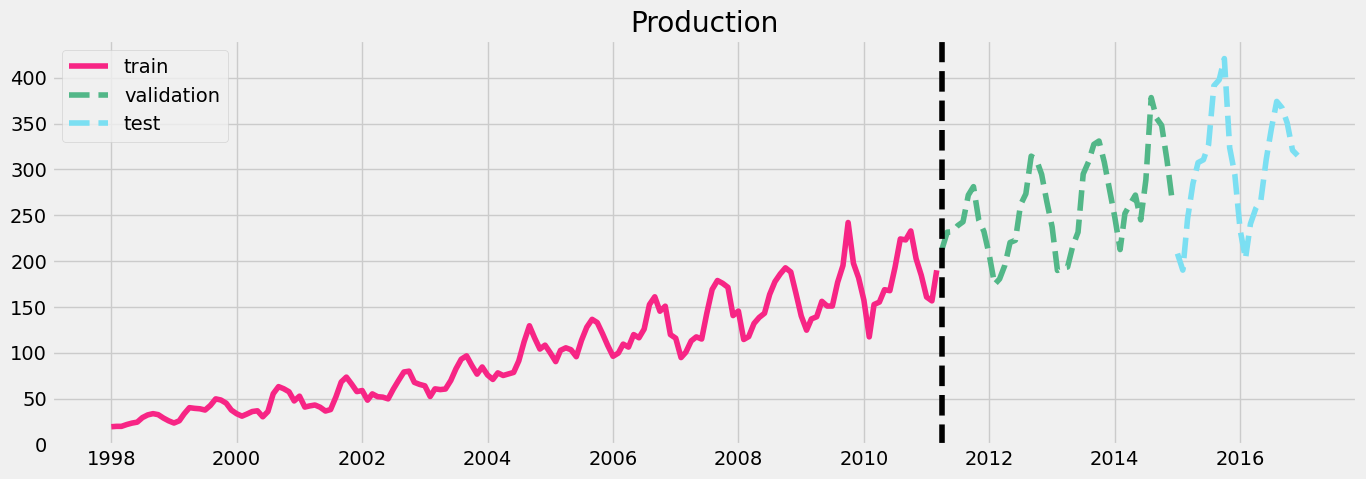

In [497]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(train_data, color=color_pal[0], label="train")
plt.plot(val_data, color=color_pal[3], linestyle="--", label="validation")
plt.plot(test_data,  color=color_pal[2],  linestyle="--", label="test")
ax.axvline(val_data.index[0], color='black', ls='--')
plt.legend(loc='upper left')
plt.title(f"Production")
plt.show()

In [498]:
def fourierPrediction(y, n_predict, n_harm=5, poly_degree=1, freq_step=1):
    """
    Predict future values of a time series using Fourier analysis.

    Parameters:
    - y (np.array): Input time series data.
    - n_predict (int): Number of future values to predict.
    - poly_degree (int, optional): Degree of polynomial detrending. Default is 1 (linear).
    - freq_step (int, optional): Frequency step. Default is 1 (although unused in current version).

    Returns:
    - np.array: The original time series followed by the predicted values.
    """
    n = y.size
    t = np.arange(0, y.size)
    p = np.polyfit(t, y, poly_degree)
    y_notrend = y - np.polyval(p, t)
    y_freqdom = np.fft.fft(y_notrend)
    f = np.fft.fftfreq(y.size)
    indexes = list(range(y.size))
    indexes.sort(key=lambda i: np.absolute(f[i]))
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(y_freqdom[i]) / n
        phase = np.angle(y_freqdom[i])
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t


In [499]:
forecast = fourierPrediction(train_data, len(val_data), n_harm=24)

In [500]:
def fourierPredictionPlot(y, prediction):
    plt.plot(y.index, y, label = 'data', linewidth = 2)
    plt.plot(y.index, prediction, label = 'prediction')
    plt.legend();

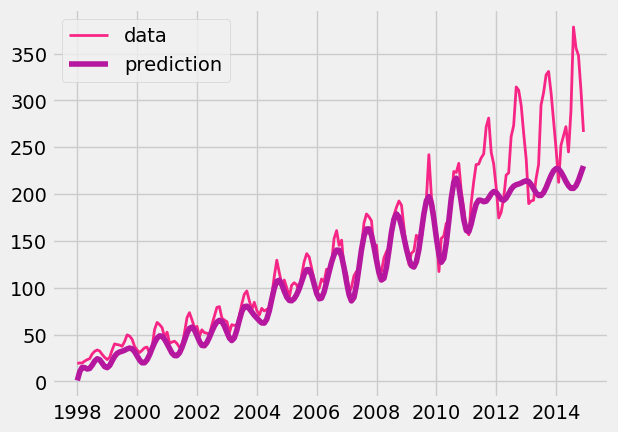

In [501]:
fourierPredictionPlot(pd.concat([train_data, val_data]), forecast)

In [502]:
from sklearn.metrics import mean_squared_error as mse
def evaluate_model(train_data, val_data, n_harm, poly_degree, freq_step=1):
    n_predict = len(val_data)
    predictions = fourierPrediction(train_data, n_predict, n_harm=n_harm, poly_degree=poly_degree, freq_step=freq_step)
    error = mse(predictions[-len(val_data):], val_data)
    return error

grid = {
    'n_harm': [1, 2, 3, 5, 10, 15, 50, 100],
    'poly_degree': [1, 2, 3, 4],
    'freq_step': [1, 2, 3]
}

results = []

for n_harm in grid['n_harm']:
    for poly_degree in grid['poly_degree']:
        for freq_step in grid['freq_step']:
            error = evaluate_model(train_data, val_data, n_harm, poly_degree, freq_step)
            results.append({
                'n_harm': n_harm,
                'poly_degree': poly_degree,
                'freq_step': freq_step,
                'mse': error
            })

results_sorted = sorted(results, key=lambda x: x['mse'])[:10]
print("Top 5 Parameters:")
for r in results_sorted:
    print(f"n_harm: {r['n_harm']}, poly_degree: {r['poly_degree']}, freq_step: {r['freq_step']}, MSE: {r['mse']}")


Top 5 Parameters:
n_harm: 3, poly_degree: 1, freq_step: 1, MSE: 4733.948646662172
n_harm: 3, poly_degree: 1, freq_step: 2, MSE: 4733.948646662172
n_harm: 3, poly_degree: 1, freq_step: 3, MSE: 4733.948646662172
n_harm: 2, poly_degree: 1, freq_step: 1, MSE: 4745.889667312337
n_harm: 2, poly_degree: 1, freq_step: 2, MSE: 4745.889667312337
n_harm: 2, poly_degree: 1, freq_step: 3, MSE: 4745.889667312337
n_harm: 5, poly_degree: 1, freq_step: 1, MSE: 4749.260589398902
n_harm: 5, poly_degree: 1, freq_step: 2, MSE: 4749.260589398902
n_harm: 5, poly_degree: 1, freq_step: 3, MSE: 4749.260589398902
n_harm: 10, poly_degree: 1, freq_step: 1, MSE: 4792.771191022219


In [503]:
combined_data = pd.concat([train_data, val_data])
best_error = float('inf')
best_params = {}
for result in results_sorted:
    n_harm =  result['n_harm']
    poly_degree = result['poly_degree']
    freq_step = result['freq_step']

    predictions = fourierPrediction(combined_data, len(test_data), n_harm, poly_degree, freq_step)
    error = mse(predictions[-len(test_data):], test_data)

    if error < best_error:
        best_error = error
        best_params = {
            'n_harm': n_harm,
            'poly_degree': poly_degree,
            'freq_step': freq_step
        }

print(best_params)

{'n_harm': 2, 'poly_degree': 1, 'freq_step': 1}


In [504]:
n_harm, poly_degree,freq_step =  best_params.values()

In [505]:
predictions = fourierPrediction(combined_data, len(test_data), n_harm, poly_degree, freq_step)

In [506]:
error = mse(predictions[-len(test_data):], test_data)

In [507]:
error

3797.49956247738

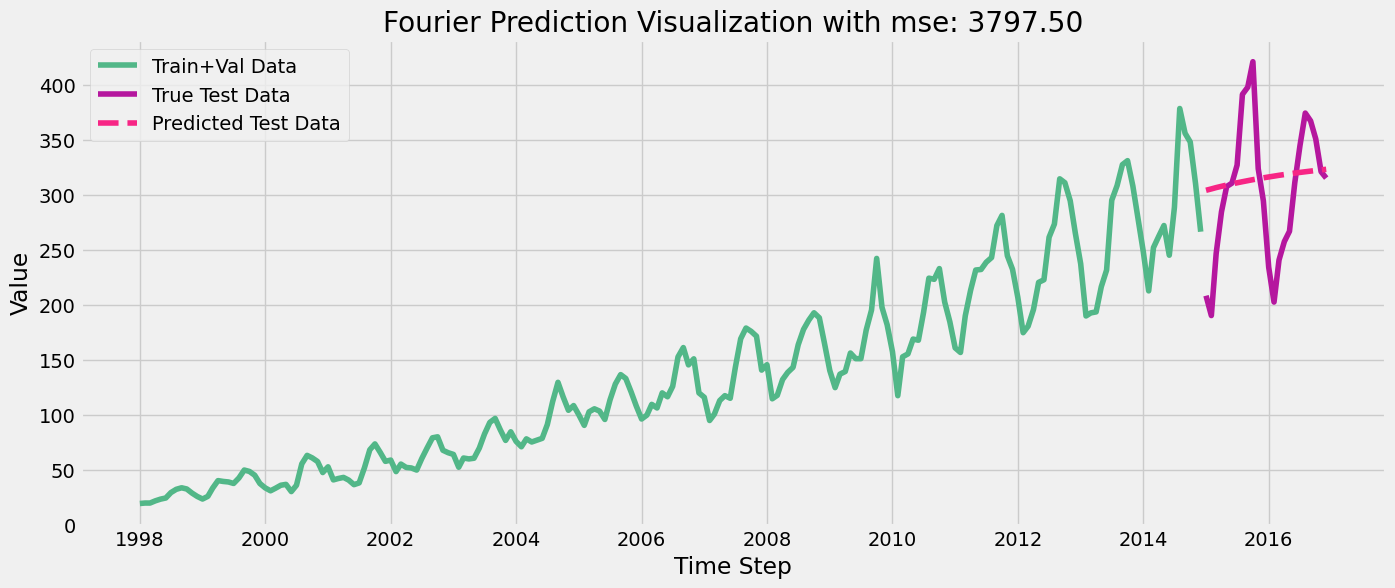

In [508]:
plt.figure(figsize=(15, 6))
plt.plot(combined_data, color=color_pal[3], label='Train+Val Data')
plt.plot(test_data, color=color_pal[1], label='True Test Data')
predicted_values = predictions[-len(test_data):]
plt.plot(test_data.index, predicted_values, color=color_pal[0], linestyle='dashed', label='Predicted Test Data')
plt.title(f'Fourier Prediction Visualization with mse: {"{:.2f}".format(error)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

Ряд Фурʼє може бути використаний для виявлення сезонних патернів. Але ефективність цього методу залежить від різних факторів, і може бути декілька причин чому цей спосіб прогнозування так погано перформить.
Наприклад, тренд, який він не вміє вловлювати, а також внесення шуму у прогноз.

Такі моделі як Prophet або XGBoost, можуть враховувати різні шаблони (тренди, сезонність, свята тощо) без явного додавання компонентів Фурʼє. У порівнянні з цими моделями проста Фурʼє-базована модель може здаватися недостатньою.

### DL підходи (1dCNN, RNN, LSTM)

In [569]:
train = data.iloc[:train_end][['Production']]
test = data.iloc[train_end:][['Production']]
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)


In [570]:
n_input = 12
n_features = 1
batch_size = 12
epochs=50
time_steps = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [571]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [572]:
time_steps = 12
X_train, y_train = create_dataset(train, train['Production'], time_steps)
X_test, y_test = create_dataset(test, test['Production'], time_steps)
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_steps, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(epochs, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/50
13/13 [==============================] - 2s 28ms/step - loss: 8031.2534 - val_loss: 4684.2983
Epoch 2/50
13/13 [==============================] - 0s 9ms/step - loss: 805.6202 - val_loss: 7378.6992
Epoch 3/50
13/13 [==============================] - 0s 10ms/step - loss: 674.6866 - val_loss: 4145.5220
Epoch 4/50
13/13 [==============================] - 0s 10ms/step - loss: 537.9244 - val_loss: 3986.5627
Epoch 5/50
13/13 [==============================] - 0s 8ms/step - loss: 527.6865 - val_loss: 4138.5981
Epoch 6/50
13/13 [==============================] - 0s 10ms/step - loss: 476.2702 - val_loss: 3660.5432
Epoch 7/50
13/13 [==============================] - 0s 10ms/step - loss: 472.2292 - val_loss: 3554.2195
Epoch 8/50
13/13 [==============================] - 0s 10ms/step - loss: 438.7532 - val_loss: 3428.5491
Epoch 9/50
13/13 [==============================] - 0s 8ms/step - loss: 419.3694 - val_loss: 3177.6816
Epoch 10/50
13/13 [==============================] - 0s 10ms/step 

2/2 [==============================] - 0s 6ms/step


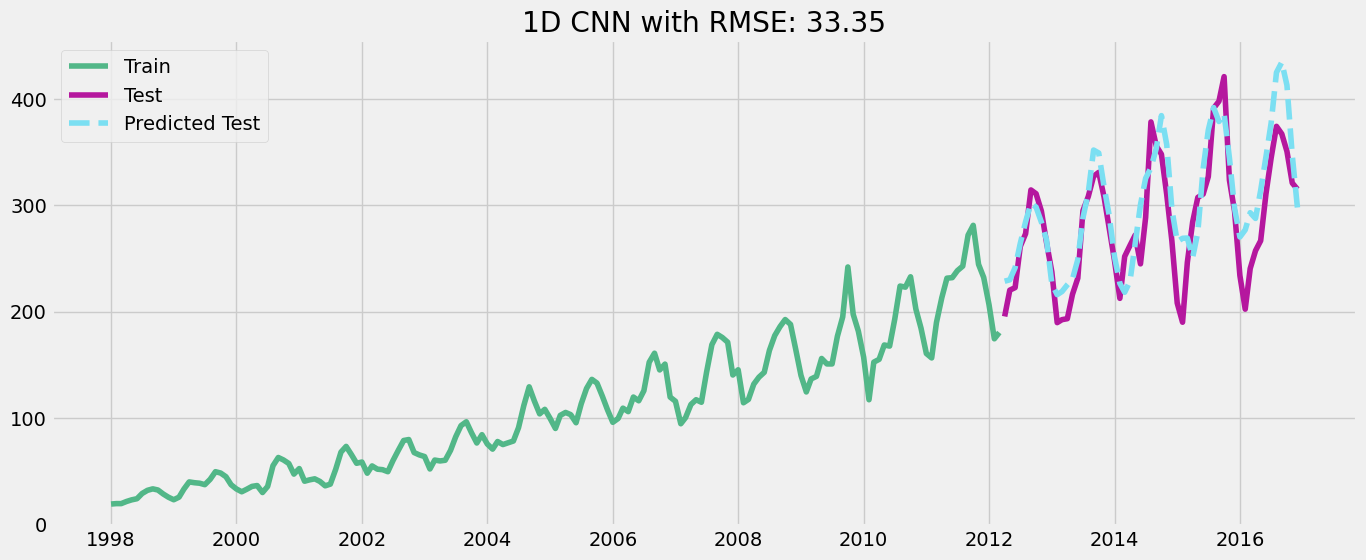

In [573]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
plt.figure(figsize=(15, 6))
df = pd.concat([train, test[:time_steps]])
plt.plot(df.index, df['Production'], color=color_pal[3], label='Train')
plt.plot(test.index[time_steps:], test['Production'].iloc[time_steps:], color=color_pal[1], label='Test')
plt.plot(test.index[time_steps:], y_pred, color=color_pal[2], linestyle='dashed', label='Predicted Test')
plt.title(f'1D CNN with RMSE: {"{:.2f}".format(rmse)}')
plt.legend()
plt.grid(True)
plt.show()

In [580]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(100, activation='relu', input_shape=(time_steps, n_features)))
model_rnn.add(Dense(n_features))
model_rnn.compile(optimizer='adam', loss='mse')


In [581]:
history = model_rnn.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test)
)
test_loss = model_rnn.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
y_pred = model_rnn.predict(X_test)
inverse_y_pred = scaler.inverse_transform(y_pred)

Epoch 1/50
13/13 [==============================] - 4s 36ms/step - loss: 11187.7188 - val_loss: 17760.1504
Epoch 2/50
13/13 [==============================] - 0s 13ms/step - loss: 1279.1522 - val_loss: 2465.9768
Epoch 3/50
13/13 [==============================] - 0s 12ms/step - loss: 443.2613 - val_loss: 2236.7056
Epoch 4/50
13/13 [==============================] - 0s 14ms/step - loss: 326.6204 - val_loss: 1806.9774
Epoch 5/50
13/13 [==============================] - 0s 12ms/step - loss: 246.9504 - val_loss: 1623.2544
Epoch 6/50
13/13 [==============================] - 0s 15ms/step - loss: 230.9460 - val_loss: 1502.9454
Epoch 7/50
13/13 [==============================] - 0s 12ms/step - loss: 232.3880 - val_loss: 1391.1471
Epoch 8/50
13/13 [==============================] - 0s 13ms/step - loss: 169.3486 - val_loss: 1062.3759
Epoch 9/50
13/13 [==============================] - 0s 13ms/step - loss: 210.5011 - val_loss: 952.6011
Epoch 10/50
13/13 [==============================] - 0s 13ms/

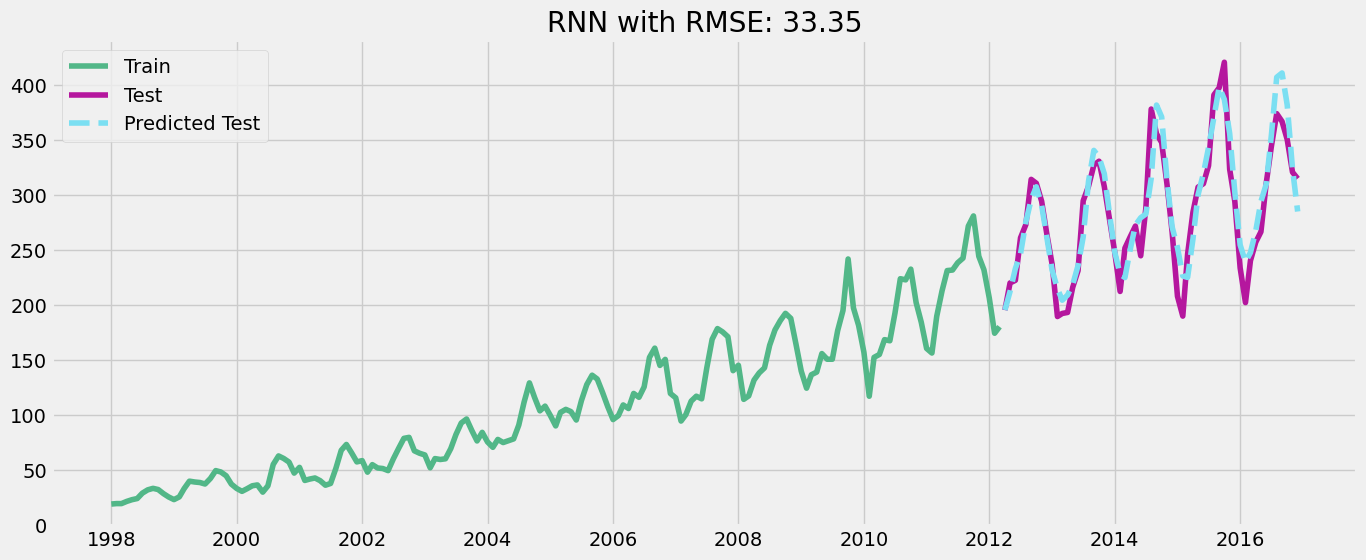

In [585]:
plt.figure(figsize=(15, 6))
df = pd.concat([train, test[:time_steps]])
plt.plot(df.index, df['Production'], color=color_pal[3], label='Train')
plt.plot(test.index[time_steps:], test['Production'].iloc[time_steps:], color=color_pal[1], label='Test')
plt.plot(test.index[time_steps:], y_pred, color=color_pal[2], linestyle='dashed', label='Predicted Test')
plt.title(f'RNN with RMSE: {"{:.2f}".format(rmse)}')
plt.legend()
plt.grid(True)
plt.show()

In [590]:
time_steps = 12
X_train, y_train = create_dataset(train, train['Production'], time_steps)
X_test, y_test = create_dataset(test, test['Production'], time_steps)
model = Sequential()

In [591]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(time_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/50
13/13 [==============================] - 3s 34ms/step - loss: 2028.1230 - val_loss: 1960.8022
Epoch 2/50
13/13 [==============================] - 0s 12ms/step - loss: 227.7346 - val_loss: 1275.1946
Epoch 3/50
13/13 [==============================] - 0s 18ms/step - loss: 212.4699 - val_loss: 1243.5188
Epoch 4/50
13/13 [==============================] - 0s 13ms/step - loss: 177.2966 - val_loss: 1512.9053
Epoch 5/50
13/13 [==============================] - 0s 13ms/step - loss: 159.6139 - val_loss: 925.6831
Epoch 6/50
13/13 [==============================] - 0s 11ms/step - loss: 166.9846 - val_loss: 1027.6737
Epoch 7/50
13/13 [==============================] - 0s 13ms/step - loss: 201.4179 - val_loss: 1340.9468
Epoch 8/50
13/13 [==============================] - 0s 12ms/step - loss: 188.8463 - val_loss: 757.8828
Epoch 9/50
13/13 [==============================] - 0s 13ms/step - loss: 152.5313 - val_loss: 987.9672
Epoch 10/50
13/13 [==============================] - 0s 13ms/step 

In [592]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

2/2 [==============================] - 1s 20ms/step


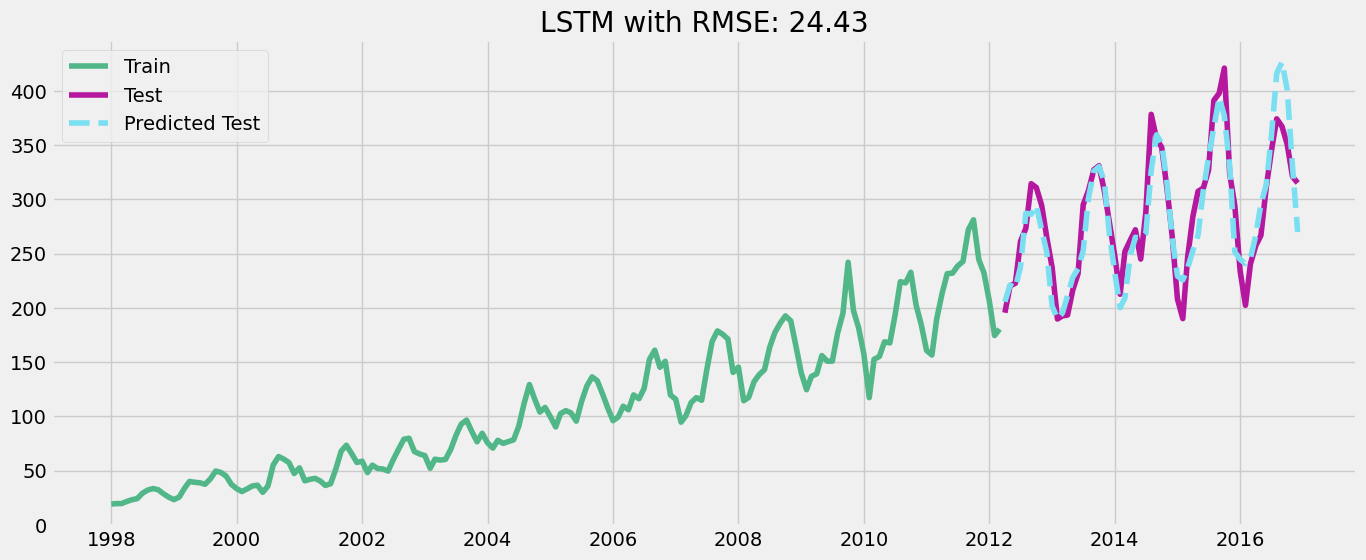

In [593]:
plt.figure(figsize=(15, 6))
df = pd.concat([train, test[:time_steps]])
plt.plot(df.index, df['Production'], color=color_pal[3], label='Train')
plt.plot(test.index[time_steps:], test['Production'].iloc[time_steps:], color=color_pal[1], label='Test')
plt.plot(test.index[time_steps:], y_pred, color=color_pal[2], linestyle='dashed', label='Predicted Test')
plt.title(f'LSTM with RMSE: {"{:.2f}".format(rmse)}')
plt.legend()
plt.grid(True)
plt.show()

У багатьох практичних застосуваннях LSTM часто краще  перформлять, ніж звичайні RNN, особливо для довших послідовностей, через їх здатність вловлювати залежності на довгий термін.
А 1d CNN не є така ефективна як попередні моделі, але може бути дуже ефективна для вловлювання патернів

### NBeats

In [603]:
def NBeatsNet(input_dim,
              theta_dim,
              horizon,
              n_hidden,
              n_blocks,
              n_stack):
    x = Input(shape=(input_dim,))
    residuals = x
    for _ in range(n_stack):
        for _ in range(n_blocks):
            block_input = Dense(n_hidden, activation='relu')(residuals)
            block_input = Dense(n_hidden, activation='relu')(block_input)
            block_input = Dense(n_hidden, activation='relu')(block_input)
            theta = Dense(theta_dim, activation='linear')(block_input)
            backcast = Lambda(lambda x: x[:, :-horizon])(theta)
            forecast = Lambda(lambda x: x[:, -horizon:])(theta)
            residuals = tf.subtract(residuals, backcast)

    y = forecast
    model = Model(inputs=x, outputs=y)
    return model


input_dim = X_train.shape[1]
y_train = y_train.reshape(-1, 1)
theta_dim = input_dim + y_train.shape[1]
horizon = y_train.shape[1]
n_hidden = 128
n_blocks = 3
n_stack = 2

model = NBeatsNet(input_dim, theta_dim, horizon, n_hidden, n_blocks, n_stack)
model.compile(loss='mse', optimizer='adam')


In [605]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/50
13/13 [==============================] - 0s 21ms/step - loss: 88.9076 - val_loss: 606.5446
Epoch 2/50
13/13 [==============================] - 0s 18ms/step - loss: 87.7383 - val_loss: 739.1394
Epoch 3/50
13/13 [==============================] - 0s 16ms/step - loss: 72.8820 - val_loss: 506.8523
Epoch 4/50
13/13 [==============================] - 0s 16ms/step - loss: 87.4441 - val_loss: 712.8960
Epoch 5/50
13/13 [==============================] - 0s 20ms/step - loss: 76.0537 - val_loss: 1191.4271
Epoch 6/50
13/13 [==============================] - 0s 17ms/step - loss: 122.3411 - val_loss: 618.1803
Epoch 7/50
13/13 [==============================] - 0s 16ms/step - loss: 96.9206 - val_loss: 1136.7983
Epoch 8/50
13/13 [==============================] - 0s 16ms/step - loss: 132.8571 - val_loss: 1942.6215
Epoch 9/50
13/13 [==============================] - 0s 16ms/step - loss: 144.6995 - val_loss: 609.5552
Epoch 10/50
13/13 [==============================] - 0s 16ms/step - loss: 10

In [597]:
y_pred = model.predict(X_test)


2/2 [==============================] - 0s 10ms/step


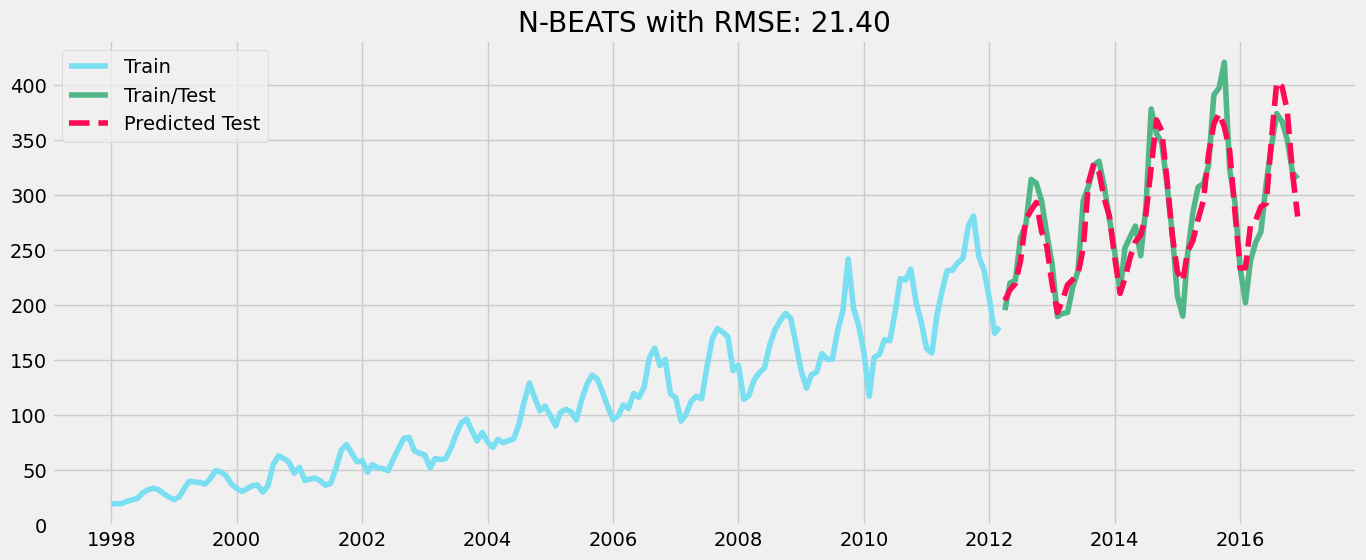

In [616]:
plt.figure(figsize=(15, 6))
df = pd.concat([train['Production'], test['Production'].iloc[:time_steps]])
plt.plot(df.index, df, color=color_pal[2], label='Train')
plt.plot(test.index[time_steps:],test['Production'].iloc[time_steps:] , color=color_pal[3], label='Train/Test')
plt.plot(test.index[time_steps:], y_pred, color=color_pal[4], linestyle='dashed', label='Predicted Test')
rmse_val = np.sqrt(mean_squared_error(test['Production'].iloc[time_steps:], y_pred))
plt.title(f'N-BEATS with RMSE: {"{:.2f}".format(rmse_val)}')
plt.legend()
plt.grid(True)
plt.show()

### Висновки щодо того, яку модель краще використовувати; прогноз на наступний рік


Загалом, більшість моделей перформлять дуже добре, на разі найкраще справляється NBeats враховуючи її RMSE на даному датасеті. Але залежно від поставленої задачі прогнозування, обʼєму даних, наявності мультиплікативного/адитивного компоненту вибір може змінюватися.

Мої фаворити модей такі:


1.   Prophet, так як проста у використанні, автоматично виявляє тренди та сезонність, може враховувати свята та вихідні.
2.   LSTM, так як добре перформить на нелінійних даних із залежностями. Може автоматично виявляти складні закономірності у даних.
3.  NBeats, так як, на мою думку, це дуже прогресивна модель глибокого навчання, яка може ефективно враховувати тренд, сезонність та інші фактори.

Прогноз на наступний рік хочу зробити використовуючи Facebook Prophet та LSTM,так як моделі надзвичайно прості та швидкі у використанні.

In [634]:
production_prophet = data.reset_index() \
    .rename(columns={'Date':'ds',
                     'Production':'y'})

In [637]:
production_prophet = production_prophet[['y', 'ds']]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0kv50uwr/mqrh1ux1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0kv50uwr/6ikanr3n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=260', 'data', 'file=/tmp/tmp0kv50uwr/mqrh1ux1.json', 'init=/tmp/tmp0kv50uwr/6ikanr3n.json', 'output', 'file=/tmp/tmp0kv50uwr/prophet_model1n82swud/prophet_model-20231031154612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:46:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:46:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds        yhat  yhat_lower  yhat_upper
588 2017-11-27  349.392664  324.244050  375.564260
589 2017-11-28  350.829606  324.587608  378.123239
590 2017-11-29  351.055005  325.675702  378.115744
591 2017-11-30  349.971713  322.987026  375.710340
592 2017-12-01  347.522616  321.490234  375.263189


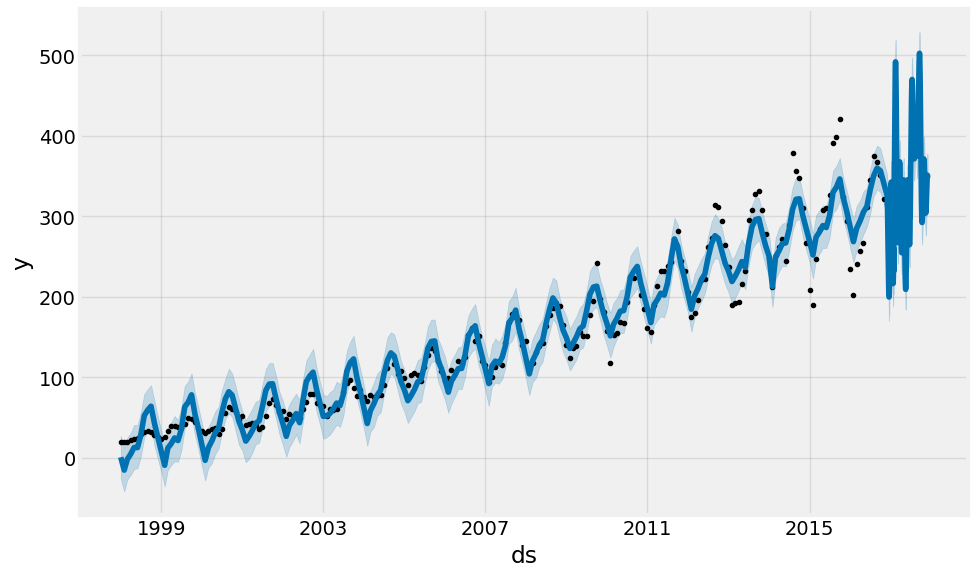

In [654]:
model = Prophet()
model.add_country_holidays(country_name='MY')
model.fit(production_prophet)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
fig = model.plot(forecast)

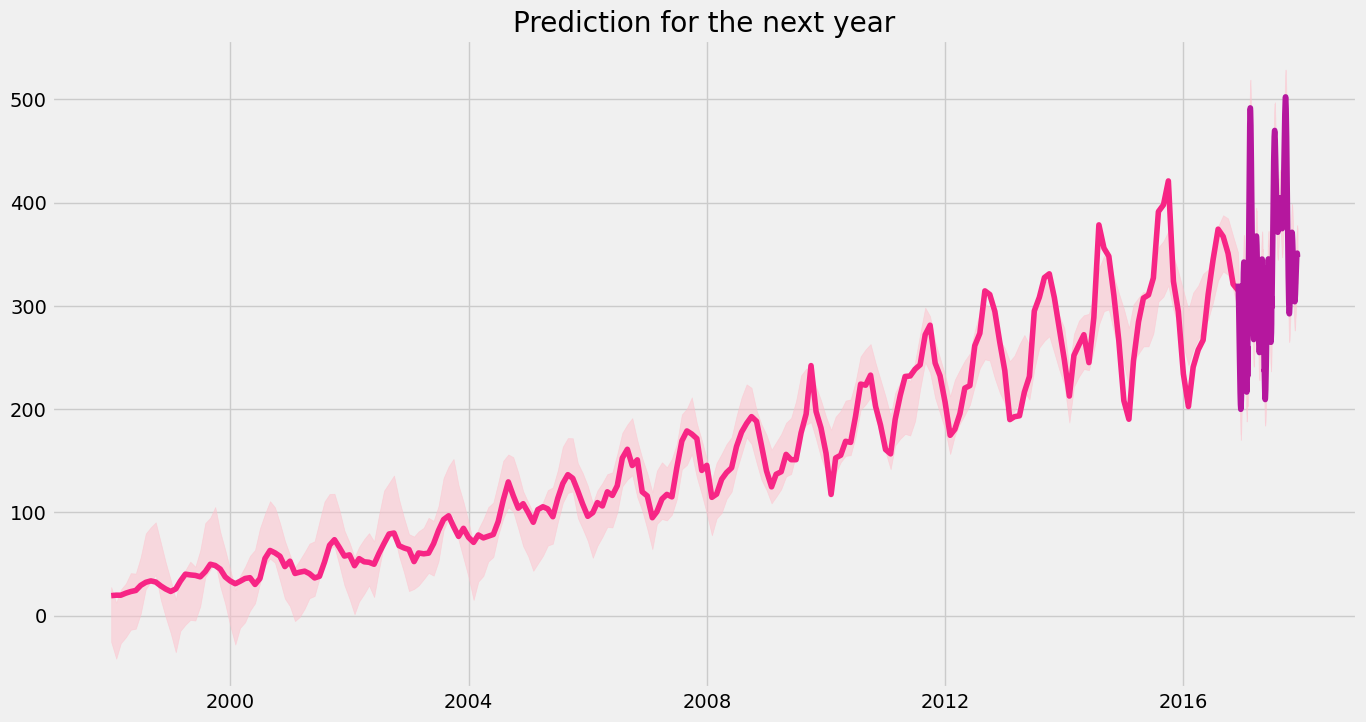

In [657]:
plt.figure(figsize=(15, 8))
plt.plot(production_prophet['ds'], production_prophet['y'], label='Train/Valid Actual', color=color_pal[0])
plt.plot(forecast['ds'][-365:], forecast['yhat'][-365:], label='Predicted',  color=color_pal[1])
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.5)
plt.title('Prediction for the next year')
plt.show()


In [710]:
given_data_values = data['Production'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_given_data = scaler.fit_transform(given_data_values)

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 12
X, Y = create_dataset(scaled_given_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
model = Sequential()
model.add(LSTM(100, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=batch_size)

predictions = []
current_batch = scaled_given_data[-look_back:]
current_batch = current_batch.reshape((1, look_back, 1))

for i in range(12):
    predicted_value = model.predict(current_batch)[0]
    predictions.append(predicted_value)
    current_batch = np.append(current_batch[:,1:,:], [[predicted_value]], axis=1)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))


Epoch 1/100
18/18 [==============================] - 3s 14ms/step - loss: 0.0542
Epoch 2/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0125
Epoch 3/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0098
Epoch 4/100
18/18 [==============================] - 0s 21ms/step - loss: 0.0091
Epoch 5/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0091
Epoch 6/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0082
Epoch 7/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0080
Epoch 8/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0079
Epoch 9/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0077
Epoch 10/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0073
Epoch 11/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0076
Epoch 12/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0068
Epoch 13/100
18/18 [=====

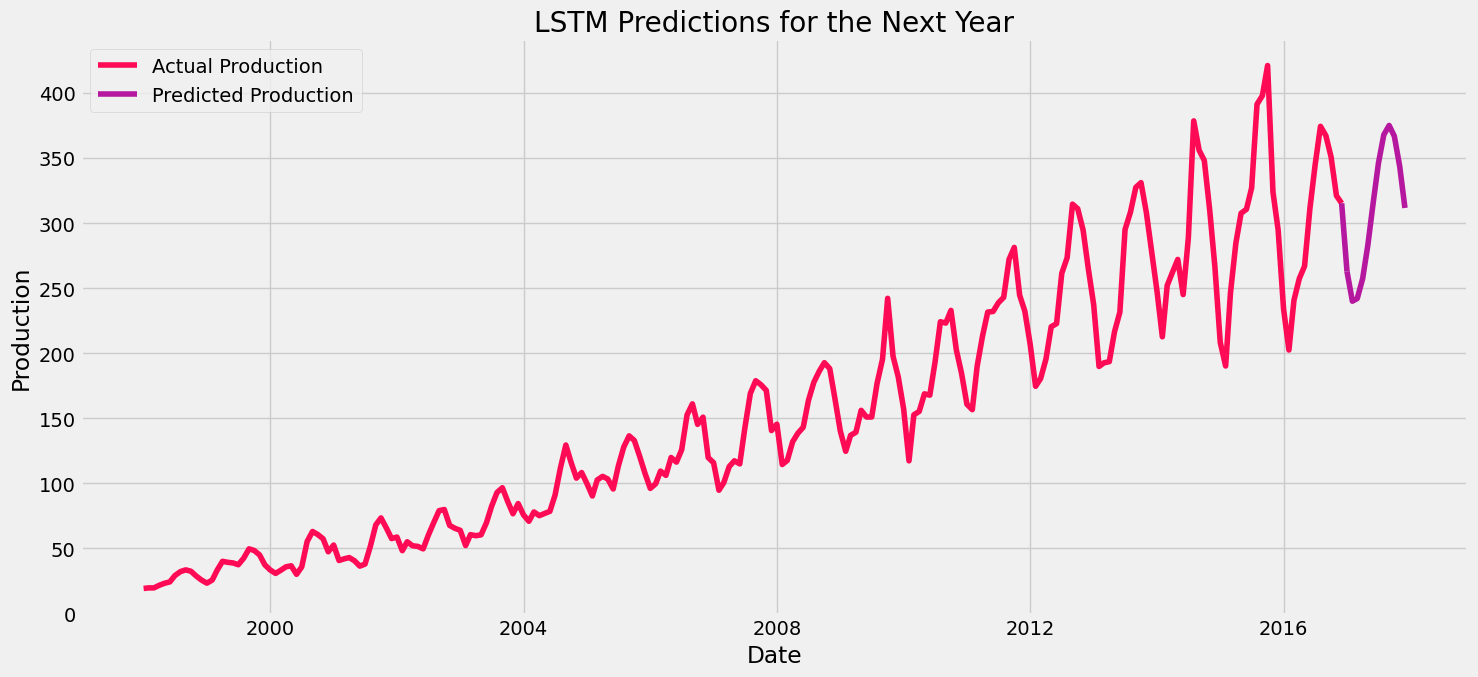

In [731]:
last_date = data.index[-1]
next_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=12, freq='MS')
plt.figure(figsize=(15, 7))
plt.plot(data['Production'],color=color_pal[4],label='Actual Production')
last_actual = data['Production'].iloc[-1]
first_prediction = predictions[0]
plt.plot([last_date, next_dates[0]], [last_actual, first_prediction], color=color_pal[1])
plt.plot(next_dates, predictions, color=color_pal[1], label='Predicted Production')

plt.title("LSTM Predictions for the Next Year")
plt.xlabel("Date")
plt.ylabel("Production")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Очевидно, що LSTM прогнозує набагато краще майбутні результати